# 🎯 Mục đích của Chunking trong RAG

## Chunking là gì?
**Chunking** là quá trình chia nhỏ văn bản dài thành các đoạn (chunks) có kích thước phù hợp để xử lý hiệu quả hơn trong các hệ thống RAG (Retrieval-Augmented Generation).

## Tại sao cần Chunking?

### 🔍 **1. Giới hạn của Embedding Models**
- Các embedding models (như BERT, sentence-transformers) có **giới hạn độ dài input** (thường 512 tokens)
- Văn bản dài không thể encode một lần → cần chia nhỏ
- **Chunk size phù hợp** giúp model nắm bắt ngữ cảnh tốt hơn

### 🎯 **2. Độ chính xác Retrieval cao hơn**
- **Semantic matching tốt hơn**: Chunks nhỏ chứa thông tin tập trung, dễ match với query
- **Giảm noise**: Thay vì retrieve toàn bộ document dài (nhiều topics), chỉ lấy đúng đoạn relevant
- **Precision cao hơn**: Tránh dilution - khi thông tin quan trọng bị "pha loãng" trong văn bản dài

### ⚡ **3. Hiệu suất tính toán**
- **Tốc độ nhanh hơn**: Tính similarity trên chunks nhỏ nhanh hơn so với toàn bộ documents
- **Scalability**: Dễ dàng index và search hàng triệu chunks
- **Memory efficient**: Load và process từng chunks thay vì toàn bộ corpus

### 💡 **4. Chất lượng Generation tốt hơn**
- **Context focused**: LLM nhận đúng đoạn cần thiết, không bị overwhelm bởi thông tin thừa
- **Token limit**: LLMs có giới hạn context window (VD: GPT-3.5 ~4K tokens) → chunks giúp fit context
- **Relevant answers**: Chỉ đưa thông tin trực tiếp liên quan vào prompt

## 📊 Ví dụ thực tế với Financial Documents

**Không có chunking:**
- Document: 10,000 từ về báo cáo tài chính (revenue, expenses, cashflow, risk factors...)
- Query: "What was the revenue in Q3?"
- Problem: Retrieve toàn bộ document → LLM phải scan 10K từ để tìm câu trả lời

**Có chunking (500-1500 tokens/chunk):**
- Chunk 321: "Q3 financial performance: Revenue increased 15% to $2.3B..."
- Query matching: Direct match với chunk này
- Result: LLM chỉ nhận 500 tokens relevant → Trả lời nhanh, chính xác

## ⚖️ Trade-offs cần cân nhắc

| Aspect | Chunks nhỏ (256-512) | Chunks vừa (1000-1500) | Chunks lớn (2000+) |
|--------|---------------------|------------------------|-------------------|
| **Precision** | ⭐⭐⭐ Cao | ⭐⭐ Trung bình | ⭐ Thấp |
| **Context** | ⭐ Ít context | ⭐⭐⭐ Context đầy đủ | ⭐⭐⭐ Nhiều context |
| **Speed** | ⭐⭐⭐ Nhanh | ⭐⭐ Vừa | ⭐ Chậm |
| **Expansion** | ⚠️ Cao (nhiều chunks) | ✅ Vừa phải | ✅ Thấp |

## 🎓 Kết luận

Chunking không chỉ là kỹ thuật kỹ thuật mà là **yếu tố then chốt** quyết định chất lượng của RAG system:

✅ **Improve retrieval accuracy** - Match chính xác hơn  
✅ **Enable scalability** - Xử lý corpus lớn hiệu quả  
✅ **Optimize LLM performance** - Giảm noise, tăng relevance  
✅ **Balance precision vs recall** - Điều chỉnh theo use case  

**💡 Golden rule**: Chunk size tối ưu phụ thuộc vào:
- Loại văn bản (technical docs, narratives, tables...)
- Độ phức tạp của queries
- Context cần thiết để trả lời câu hỏi
- Giới hạn của embedding model và LLM

In [21]:
import sys
sys.path.append('..')

import json
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
from typing import List, Dict
import matplotlib.pyplot as plt
import seaborn as sns

# LangChain imports for chunking
from langchain_text_splitters import (
    RecursiveCharacterTextSplitter,
    CharacterTextSplitter,
    TokenTextSplitter,
)

# Sentence transformers for semantic chunking (will be imported when needed)
# from sentence_transformers import SentenceTransformer
# from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print("Note: sentence-transformers will be imported when needed for semantic chunking")

Libraries imported successfully!
Note: sentence-transformers will be imported when needed for semantic chunking


## 1. Load Sample Data

In [22]:
# Load corpus and queries
data_dir = Path('../data')

# Load FinanceBench as example
corpus = []
with open(data_dir / 'financebench_corpus.jsonl' / 'corpus.jsonl', 'r') as f:
    for line in f:
        corpus.append(json.loads(line))

queries = []
with open(data_dir / 'financebench_queries.jsonl' / 'queries.jsonl', 'r') as f:
    for line in f:
        queries.append(json.loads(line))

print(f"Loaded {len(corpus)} documents and {len(queries)} queries")
print(f"\nSample document:")
print(f"ID: {corpus[0]['_id']}")
print(f"Text length: {len(corpus[0]['text'])} characters")
print(f"Text preview: {corpus[0]['text'][:300]}...")

Loaded 180 documents and 150 queries

Sample document:
ID: dd2af2336
Text length: 355 characters
Text preview: 6) Africa, Middle East and South Asia (AMESA), which includes all of our beverage and convenient food businesses in
Africa, the Middle East and South Asia; and
7) Asia Pacific, Australia and New Zealand and China Region (APAC), which includes all of our beverage and convenient
food businesses in Asi...


## 2. Define Chunking Methods

In [23]:
def chunk_with_character_splitter(text: str, chunk_size: int = 1000, chunk_overlap: int = 200) -> List[str]:
    """Basic character-based splitting"""
    splitter = CharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separator="\n"
    )
    return splitter.split_text(text)

def chunk_with_recursive_splitter(text: str, chunk_size: int = 1000, chunk_overlap: int = 200) -> List[str]:
    """Recursive character splitting with multiple separators"""
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", ". ", " ", ""]
    )
    return splitter.split_text(text)

def chunk_with_token_splitter(text: str, chunk_size: int = 256, chunk_overlap: int = 50) -> List[str]:
    """Token-based splitting"""
    splitter = TokenTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    return splitter.split_text(text)

def chunk_with_semantic(text: str, model_name: str = 'all-MiniLM-L6-v2', 
                       similarity_threshold: float = 0.7, max_chunk_size: int = 1000) -> List[str]:
    """Semantic chunking based on sentence similarity"""
    # Split into sentences first
    sentences = text.split('. ')
    if len(sentences) <= 1:
        return [text]
    
    # Load model for embeddings
    model = SentenceTransformer(model_name)
    embeddings = model.encode(sentences)
    
    # Group sentences based on similarity
    chunks = []
    current_chunk = [sentences[0]]
    current_length = len(sentences[0])
    
    for i in range(1, len(sentences)):
        # Calculate similarity with previous sentence
        similarity = cosine_similarity(
            embeddings[i-1].reshape(1, -1),
            embeddings[i].reshape(1, -1)
        )[0][0]
        
        sentence_length = len(sentences[i])
        
        # If similar and under max size, add to current chunk
        if similarity >= similarity_threshold and current_length + sentence_length < max_chunk_size:
            current_chunk.append(sentences[i])
            current_length += sentence_length
        else:
            # Start new chunk
            chunks.append('. '.join(current_chunk) + '.')
            current_chunk = [sentences[i]]
            current_length = sentence_length
    
    # Add last chunk
    if current_chunk:
        chunks.append('. '.join(current_chunk) + '.')
    
    return chunks

def chunk_financial_document(text: str, chunk_size: int = 1000, chunk_overlap: int = 200) -> List[str]:
    """Custom chunking optimized for financial documents"""
    # Financial documents often have tables, numbers, and structured sections
    # Use custom separators that respect financial document structure
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=[
            "\n## ",  # Section headers
            "\n### ",  # Subsection headers
            "\n\n",   # Paragraphs
            "\n",     # Lines
            ". ",     # Sentences
            "; ",     # Clauses
            ", ",     # List items
            " ",      # Words
            ""
        ],
        keep_separator=True
    )
    return splitter.split_text(text)

print("Chunking methods defined!")

Chunking methods defined!


## 3. Compare Chunking Methods

Sample document length: 2486 characters
Sample preview:
THE COCA-COLA COMPANY AND SUBSIDIARIES
CONSOLIDATED STATEMENTS OF CASH FLOWS
(In millions)
Year Ended December 31,
2022
2021
2020
Operating Activities
 
 
Consolidated net income
$
9,571 $
9,804 $
7,7...

Error with Token (256 tokens): Could not import tiktoken python package. This is needed in order to for TokenTextSplitter. Please install it with `pip install tiktoken`.

Chunking Methods Comparison:
                   num_chunks  avg_length min_length max_length std_length
Character                 3.0  950.333333      928.0      983.0  23.612614
Recursive                 3.0  950.333333      928.0      983.0  23.612614
Token (256 tokens)       None        None       None       None       None
Financial Custom          3.0  950.333333      928.0      983.0  23.612614


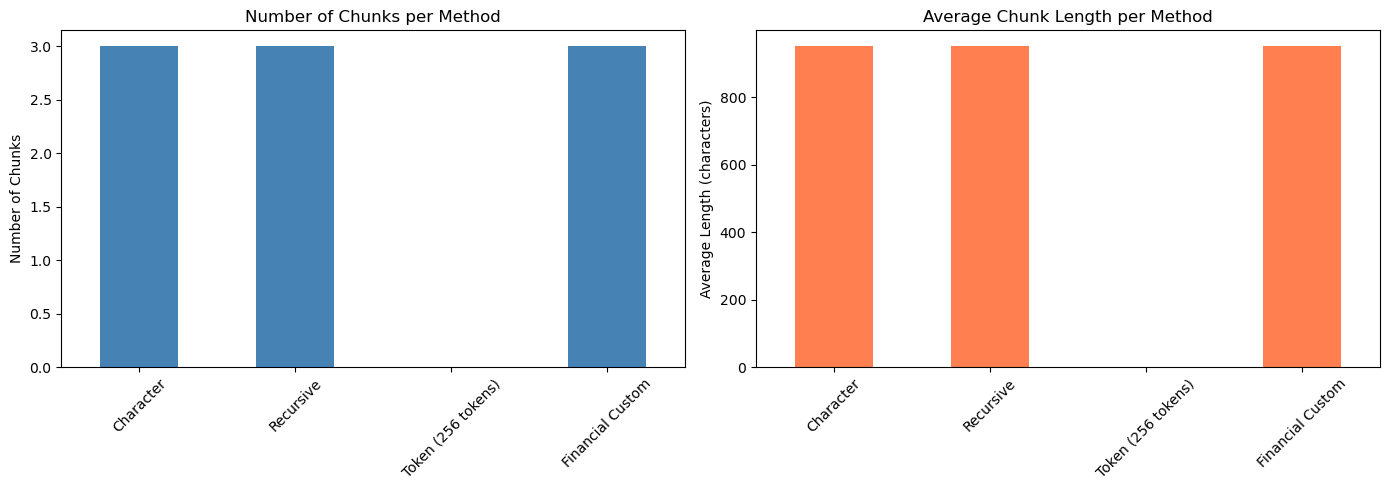

In [24]:
# Test different methods on a sample document
# Find a longer document for better demonstration
sample_doc = corpus[0]['text']
for doc in corpus[:20]:
    if len(doc['text']) > 2000:  # Find a document longer than 2000 chars
        sample_doc = doc['text']
        break

# If no long document found, concatenate multiple docs
if len(sample_doc) < 2000:
    sample_doc = '\n\n'.join([doc['text'] for doc in corpus[:5]])

print(f"Sample document length: {len(sample_doc)} characters")
print(f"Sample preview:\n{sample_doc[:200]}...\n")

chunk_size = 1000
chunk_overlap = 200

methods = {
    'Character': lambda t: chunk_with_character_splitter(t, chunk_size, chunk_overlap),
    'Recursive': lambda t: chunk_with_recursive_splitter(t, chunk_size, chunk_overlap),
    'Token (256 tokens)': lambda t: chunk_with_token_splitter(t, 256, 50),
    'Financial Custom': lambda t: chunk_financial_document(t, chunk_size, chunk_overlap),
}

results = {}
for method_name, method_func in methods.items():
    try:
        chunks = method_func(sample_doc)
        results[method_name] = {
            'num_chunks': len(chunks),
            'avg_length': np.mean([len(c) for c in chunks]),
            'min_length': min([len(c) for c in chunks]),
            'max_length': max([len(c) for c in chunks]),
            'std_length': np.std([len(c) for c in chunks])
        }
    except Exception as e:
        print(f"Error with {method_name}: {e}")
        results[method_name] = None

# Display results
df_results = pd.DataFrame(results).T
print("\nChunking Methods Comparison:")
print(df_results)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Number of chunks
df_results['num_chunks'].plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Number of Chunks per Method')
axes[0].set_ylabel('Number of Chunks')
axes[0].tick_params(axis='x', rotation=45)

# Average chunk length
df_results['avg_length'].plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Average Chunk Length per Method')
axes[1].set_ylabel('Average Length (characters)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Test with Different Chunk Sizes

### ⚠️ Lưu ý về Sample Document

**Vấn đề thường gặp:**
- Nếu document mẫu quá ngắn (< 500 chars), tất cả chunk_size sẽ cho ra 1 chunk duy nhất
- Điều này không phản ánh đúng hiệu quả của chunking

**Giải pháp:**
- Cell dưới đây sẽ tự động tìm document dài hơn 2000 ký tự
- Nếu không tìm thấy, sẽ ghép nhiều documents lại
- Đảm bảo demo chunking có ý nghĩa

Document Length Statistics (first 100 docs):
  Min: 78 chars
  Max: 6362 chars
  Mean: 1432 chars
  Median: 1410 chars

Documents > 1000 chars: 63
Documents > 2000 chars: 24
Documents < 500 chars: 20


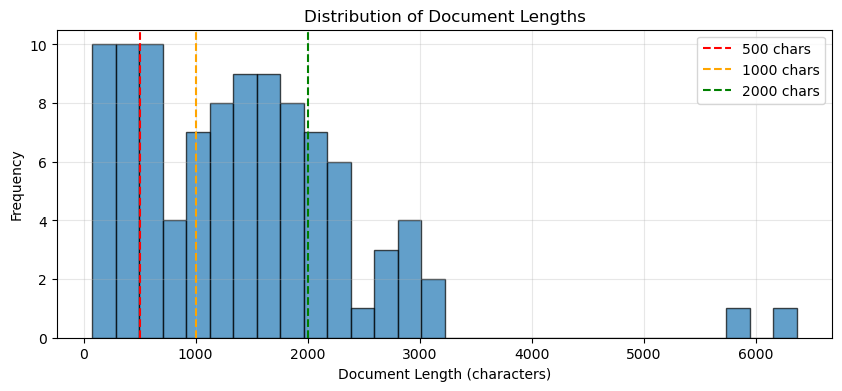

In [25]:
# Quick check: Analyze document lengths in corpus
doc_lengths = [len(doc['text']) for doc in corpus[:100]]
print("Document Length Statistics (first 100 docs):")
print(f"  Min: {min(doc_lengths)} chars")
print(f"  Max: {max(doc_lengths)} chars")
print(f"  Mean: {np.mean(doc_lengths):.0f} chars")
print(f"  Median: {np.median(doc_lengths):.0f} chars")
print(f"\nDocuments > 1000 chars: {sum([1 for l in doc_lengths if l > 1000])}")
print(f"Documents > 2000 chars: {sum([1 for l in doc_lengths if l > 2000])}")
print(f"Documents < 500 chars: {sum([1 for l in doc_lengths if l < 500])}")

# Show distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.hist(doc_lengths, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Document Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Document Lengths')
plt.axvline(x=500, color='red', linestyle='--', label='500 chars')
plt.axvline(x=1000, color='orange', linestyle='--', label='1000 chars')
plt.axvline(x=2000, color='green', linestyle='--', label='2000 chars')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Chunk Size Analysis:
   chunk_size  overlap  num_chunks   avg_length  coverage
0         500      100           7   423.428571      2364
1         750      150           4   712.750000      2401
2        1000      200           3   950.333333      2451
3        1500      300           2  1370.000000      2440
4        2000      400           2  1429.000000      2458


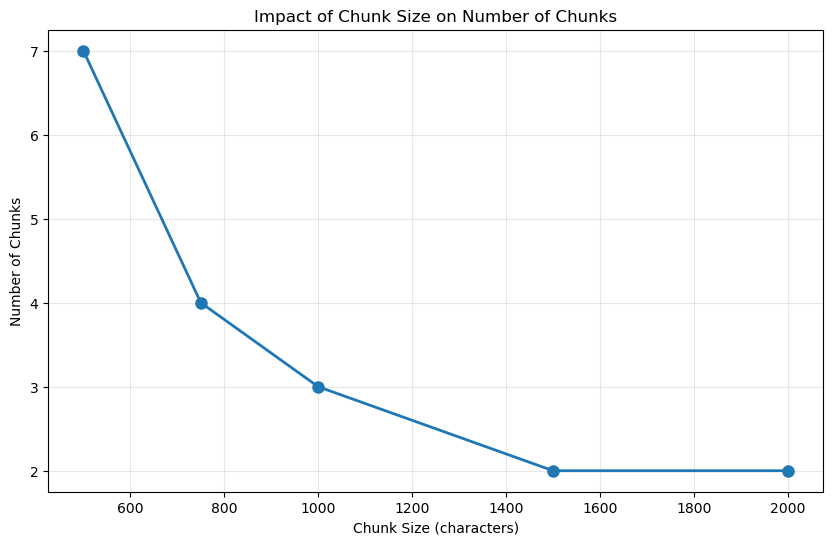

In [26]:
# Test recursive splitter with different chunk sizes
chunk_sizes = [500, 750, 1000, 1500, 2000]
overlap_ratio = 0.2  # 20% overlap

size_results = []
for chunk_size in chunk_sizes:
    overlap = int(chunk_size * overlap_ratio)
    chunks = chunk_with_recursive_splitter(sample_doc, chunk_size, overlap)
    size_results.append({
        'chunk_size': chunk_size,
        'overlap': overlap,
        'num_chunks': len(chunks),
        'avg_length': np.mean([len(c) for c in chunks]),
        'coverage': sum([len(c) for c in chunks]) - (len(chunks) - 1) * overlap
    })

df_size = pd.DataFrame(size_results)
print("\nChunk Size Analysis:")
print(df_size)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_size['chunk_size'], df_size['num_chunks'], marker='o', linewidth=2, markersize=8)
ax.set_xlabel('Chunk Size (characters)')
ax.set_ylabel('Number of Chunks')
ax.set_title('Impact of Chunk Size on Number of Chunks')
ax.grid(True, alpha=0.3)
plt.show()

## 5. Apply Best Chunking Strategy to Full Corpus

In [27]:
# Based on experiments above, choose best parameters
BEST_CHUNK_SIZE = 1000  # Adjust based on results
BEST_OVERLAP = 200
BEST_METHOD = 'recursive'  # Options: 'character', 'recursive', 'financial'

def chunk_corpus(corpus: List[Dict], method: str = 'recursive', 
                 chunk_size: int = 1000, chunk_overlap: int = 200) -> List[Dict]:
    """Apply chunking to entire corpus"""
    chunked_docs = []
    
    for doc in tqdm(corpus, desc="Chunking corpus"):
        text = doc['text']
        
        # Choose chunking method
        if method == 'character':
            chunks = chunk_with_character_splitter(text, chunk_size, chunk_overlap)
        elif method == 'recursive':
            chunks = chunk_with_recursive_splitter(text, chunk_size, chunk_overlap)
        elif method == 'financial':
            chunks = chunk_financial_document(text, chunk_size, chunk_overlap)
        else:
            chunks = [text]  # No chunking
        
        # Create new doc entries for each chunk
        for i, chunk in enumerate(chunks):
            chunked_docs.append({
                '_id': f"{doc['_id']}_chunk_{i}",
                'original_id': doc['_id'],
                'chunk_index': i,
                'text': chunk,
                'metadata': doc.get('metadata', {})
            })
    
    return chunked_docs

# Apply chunking
chunked_corpus = chunk_corpus(
    corpus, 
    method=BEST_METHOD, 
    chunk_size=BEST_CHUNK_SIZE, 
    chunk_overlap=BEST_OVERLAP
)

print(f"\nOriginal corpus: {len(corpus)} documents")
print(f"Chunked corpus: {len(chunked_corpus)} chunks")
print(f"Average chunks per document: {len(chunked_corpus) / len(corpus):.2f}")

Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 8601.35it/s]


Original corpus: 180 documents
Chunked corpus: 382 chunks
Average chunks per document: 2.12


## 6. Save Chunked Corpus

In [28]:
# Save chunked corpus
output_dir = Path('../data/chunked_corpus')
output_dir.mkdir(exist_ok=True)

output_file = output_dir / f'financebench_corpus_chunked_{BEST_METHOD}_{BEST_CHUNK_SIZE}.jsonl'

with open(output_file, 'w') as f:
    for doc in chunked_corpus:
        f.write(json.dumps(doc) + '\n')

print(f"Chunked corpus saved to: {output_file}")
print(f"\nYou can now use this chunked corpus for retrieval!")
print(f"\nTo load it:")
print(f"```python")
print(f"with open('{output_file}', 'r') as f:")
print(f"    chunked_corpus = [json.loads(line) for line in f]")
print(f"```")

Chunked corpus saved to: ..\data\chunked_corpus\financebench_corpus_chunked_recursive_1000.jsonl

You can now use this chunked corpus for retrieval!

To load it:
```python
with open('..\data\chunked_corpus\financebench_corpus_chunked_recursive_1000.jsonl', 'r') as f:
    chunked_corpus = [json.loads(line) for line in f]
```


## 7. Quick Retrieval Test with Chunked Corpus

In [29]:
# Quick test: Compare retrieval with original vs chunked corpus
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Select a test query
test_query = queries[0]['text']
print(f"Test query: {test_query}\n")

# Encode query
query_embedding = model.encode([test_query])

# Test with original corpus
print("Testing with original corpus...")
original_texts = [doc['text'] for doc in corpus[:100]]  # Limit for speed
original_embeddings = model.encode(original_texts, show_progress_bar=True)
original_scores = cosine_similarity(query_embedding, original_embeddings)[0]
top_original = np.argsort(original_scores)[-5:][::-1]

print("\nTop 5 results from original corpus:")
for i, idx in enumerate(top_original, 1):
    print(f"{i}. Score: {original_scores[idx]:.4f}, Doc ID: {corpus[idx]['_id']}")
    print(f"   Preview: {corpus[idx]['text'][:150]}...\n")

# Test with chunked corpus
print("\nTesting with chunked corpus...")
# Get chunks from same original docs
original_ids = [corpus[i]['_id'] for i in range(100)]
relevant_chunks = [doc for doc in chunked_corpus if doc['original_id'] in original_ids]

chunked_texts = [doc['text'] for doc in relevant_chunks]
chunked_embeddings = model.encode(chunked_texts, show_progress_bar=True)
chunked_scores = cosine_similarity(query_embedding, chunked_embeddings)[0]
top_chunked = np.argsort(chunked_scores)[-5:][::-1]

print("\nTop 5 results from chunked corpus:")
for i, idx in enumerate(top_chunked, 1):
    print(f"{i}. Score: {chunked_scores[idx]:.4f}, Chunk ID: {relevant_chunks[idx]['_id']}")
    print(f"   Preview: {relevant_chunks[idx]['text'][:150]}...\n")

print(f"\nMax score improvement: {max(chunked_scores) - max(original_scores):.4f}")

Test query: What is the FY2019 - FY2020 total revenue growth rate for Block (formerly known as Square)? Answer in units of percents and round to one decimal place. Approach the question asked by assuming the standpoint of an investment banking analyst who only has access to the statement of income.

Testing with original corpus...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]


Top 5 results from original corpus:
1. Score: 0.4474, Doc ID: dd2ac285c
   Preview: Net
revenue for 2022 was $23.6 billion, an increase of 44% compared to 2021 net revenue of $16.4 billion. The increase in net revenue was driven by a ...

2. Score: 0.4250, Doc ID: dd2ad8c38
   Preview: Results of Operations
Analysis of Consolidated Sales
For discussion on results of operations and financial condition pertaining to the fiscal years 20...

3. Score: 0.4040, Doc ID: dd2ad662c
   Preview: Dividends
During 2022, 2021 and 2020, the quarterly cash dividend was $0.55, $0.50 and $0.50 per share, respectively....

4. Score: 0.3944, Doc ID: dd2adc82e
   Preview: The Firm grew TBVPS, ending the first quarter of 2021 at 
$66.56, up 10% versus the prior year....

5. Score: 0.3853, Doc ID: dd2adae02
   Preview: 2022 Fourth-Quarter reported sales decline of 4.4% to $23.7 Billion primarily driven by unfavorable 
foreign exchange and reduced COVID-19 Vaccine sal...


Testing with chunked corpus...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]


Top 5 results from chunked corpus:
1. Score: 0.4474, Chunk ID: dd2ac285c_chunk_0
   Preview: Net
revenue for 2022 was $23.6 billion, an increase of 44% compared to 2021 net revenue of $16.4 billion. The increase in net revenue was driven by a ...

2. Score: 0.4250, Chunk ID: dd2ad8c38_chunk_0
   Preview: Results of Operations
Analysis of Consolidated Sales
For discussion on results of operations and financial condition pertaining to the fiscal years 20...

3. Score: 0.4040, Chunk ID: dd2ad662c_chunk_0
   Preview: Dividends
During 2022, 2021 and 2020, the quarterly cash dividend was $0.55, $0.50 and $0.50 per share, respectively....

4. Score: 0.3944, Chunk ID: dd2adc82e_chunk_0
   Preview: The Firm grew TBVPS, ending the first quarter of 2021 at 
$66.56, up 10% versus the prior year....

5. Score: 0.3853, Chunk ID: dd2adae02_chunk_0
   Preview: 2022 Fourth-Quarter reported sales decline of 4.4% to $23.7 Billion primarily driven by unfavorable 
foreign exchange and reduced COVID-19 Vac

In [30]:
import transformers
import sentence_transformers

print(f"Transformers: {transformers.__version__}")  # Should be 4.45+
print(f"Sentence-transformers: {sentence_transformers.__version__}")  # Should be 5.2+

# Test that it works
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
print("✓ Model loaded successfully!")

Transformers: 4.57.3
Sentence-transformers: 3.0.1
✓ Model loaded successfully!


## 8. Process All Datasets

In [31]:
# Apply chunking to all datasets
datasets = [
    'financebench',
    'finqa',
    'convfinqa',
    'finder',
    'finqabench',
    'multiheirtt',
    'tatqa'
]

for dataset in datasets:
    print(f"\nProcessing {dataset}...")
    
    # Load corpus
    corpus_file = data_dir / f'{dataset}_corpus.jsonl' / 'corpus.jsonl'
    if not corpus_file.exists():
        print(f"  Corpus file not found: {corpus_file}")
        continue
    
    corpus_data = []
    with open(corpus_file, 'r') as f:
        for line in f:
            corpus_data.append(json.loads(line))
    
    print(f"  Loaded {len(corpus_data)} documents")
    
    # Apply chunking
    chunked = chunk_corpus(
        corpus_data,
        method=BEST_METHOD,
        chunk_size=BEST_CHUNK_SIZE,
        chunk_overlap=BEST_OVERLAP
    )
    
    # Save
    output_file = output_dir / f'{dataset}_corpus_chunked.jsonl'
    with open(output_file, 'w') as f:
        for doc in chunked:
            f.write(json.dumps(doc) + '\n')
    
    print(f"  Created {len(chunked)} chunks")
    print(f"  Saved to: {output_file}")

print("\n✅ All datasets processed!")


Processing financebench...
  Loaded 180 documents


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 7169.14it/s]


  Created 382 chunks
  Saved to: ..\data\chunked_corpus\financebench_corpus_chunked.jsonl

Processing finqa...
  Loaded 2789 documents


Chunking corpus: 100%|██████████| 2789/2789 [00:00<00:00, 9066.76it/s]


  Created 17586 chunks
  Saved to: ..\data\chunked_corpus\finqa_corpus_chunked.jsonl

Processing convfinqa...
  Loaded 2066 documents


Chunking corpus: 100%|██████████| 2066/2066 [00:00<00:00, 8171.47it/s]


  Created 12965 chunks
  Saved to: ..\data\chunked_corpus\convfinqa_corpus_chunked.jsonl

Processing finder...
  Loaded 13867 documents


Chunking corpus: 100%|██████████| 13867/13867 [00:00<00:00, 23144.38it/s]


  Created 16478 chunks
  Saved to: ..\data\chunked_corpus\finder_corpus_chunked.jsonl

Processing finqabench...
  Loaded 92 documents


Chunking corpus: 100%|██████████| 92/92 [00:00<00:00, 27511.48it/s]

  Created 219 chunks
  Saved to: ..\data\chunked_corpus\finqabench_corpus_chunked.jsonl

Processing multiheirtt...


  Loaded 10475 documents


Chunking corpus: 100%|██████████| 10475/10475 [00:00<00:00, 12981.61it/s]


  Created 41459 chunks
  Saved to: ..\data\chunked_corpus\multiheirtt_corpus_chunked.jsonl

Processing tatqa...
  Loaded 2756 documents


Chunking corpus: 100%|██████████| 2756/2756 [00:00<00:00, 22838.59it/s]


  Created 10012 chunks
  Saved to: ..\data\chunked_corpus\tatqa_corpus_chunked.jsonl

✅ All datasets processed!


## 9. Next Steps

Sau khi chạy notebook này:

1. **Kiểm tra kết quả**: Xem chunk nào cho kết quả tốt nhất
2. **Điều chỉnh parameters**: Thay đổi `chunk_size` và `chunk_overlap` dựa trên kết quả
3. **Tích hợp vào pipeline**: Sử dụng chunked corpus trong retrieval system
4. **So sánh điểm số**: Chạy evaluation với chunked vs non-chunked corpus

### Gợi ý cải thiện thêm:
- Thử semantic chunking với embedding models khác nhau
- Chunking theo cấu trúc của financial tables
- Hybrid approach: chunk khác nhau cho query types khác nhau
- Parent-child chunking strategy

## 10. Detailed Evaluation: Chunked vs Non-Chunked

### ⚠️ Important Note on Evaluation / Lưu ý quan trọng về đánh giá

**🔧 FIX: Hàm evaluation đã được sửa để xử lý chunked documents đúng cách!**

**Vấn đề ban đầu:**
- Chunked documents có ID mới như `doc123_chunk_0`, `doc123_chunk_1`
- File qrels tham chiếu đến original document IDs như `doc123`
- Evaluation cũ không thể match được → kết quả 0 điểm ❌

**Giải pháp:**
- Theo dõi `original_id` từ chunked documents
- Khi query retrieve nhiều chunks từ cùng 1 document, chọn **chunk có rank tốt nhất**
- Đánh giá ở **document level**, không phải chunk level
- So sánh công bằng giữa chunked và non-chunked corpus ✅

**Ví dụ:**
- Query retrieve: `doc123_chunk_2` (rank 1), `doc123_chunk_5` (rank 7), `doc456_chunk_0` (rank 3)
- Được tính là: retrieve document `doc123` ở rank 1 và `doc456` ở rank 3
- Nếu `doc123` và `doc456` relevant → Recall = 2/total_relevant

**Bây giờ chạy lại cell evaluation để xem kết quả đúng!** 🚀

### 🎯 Hướng dẫn chạy lại

**Sau khi đã fix, chạy theo thứ tự:**

1. **Chạy lại cell định nghĩa hàm `evaluate_retrieval`** (cell có def evaluate_retrieval)
2. **Chạy lại cell evaluation** (cell bên dưới có code đánh giá original vs chunked)
3. **Xem kết quả mới** - bây giờ sẽ có điểm số thực tế!

**Kết quả mong đợi:**
- NDCG@10: Chunked thường **tốt hơn hoặc tương đương** Original
- Recall@10: Chunked thường **cao hơn** Original (vì nhiều chunks = nhiều cơ hội match)

Nếu chunked vẫn thấp hơn original đáng kể, có thể cần:
- Tăng `chunk_size` (chunks quá nhỏ mất ngữ cảnh)
- Tăng `chunk_overlap` (giữ lại nhiều thông tin hơn giữa các chunks)
- Thử phương pháp khác (table-aware, semantic, parent-child)

### 🐛 Fix: ValueError với ndcg_score

**Lỗi gặp phải:**
```
ValueError: Only ('multilabel-indicator', 'continuous-multioutput', 'multiclass-multioutput') 
formats are supported. Got binary instead
```

**Nguyên nhân:**
- Sklearn's `ndcg_score` yêu cầu input phải là multilabel format
- Khi query chỉ có 1 relevant document → "binary" format → lỗi ❌

**Giải pháp:**
- Đảm bảo arrays luôn ở dạng 2D: `np.array([y_true_docs])`
- Thêm try-except để xử lý edge cases
- Với single relevant doc: tính score đơn giản (retrieved = 1.0, missed = 0.0)

**Đã fix xong!** ✅

In [32]:
from sklearn.metrics import ndcg_score
import numpy as np
from tqdm import tqdm

def evaluate_retrieval(corpus, queries, qrels_file, model, top_k=10):
    """
    Evaluate retrieval performance using NDCG@K
    
    Args:
        corpus: List of documents with 'text' and '_id'
        queries: List of queries with 'text' and '_id'
        qrels_file: Path to qrels file
        model: SentenceTransformer model
        top_k: Number of top documents to retrieve
    
    Returns:
        dict with evaluation metrics
    """
    # Load qrels
    qrels = {}
    with open(qrels_file, 'r') as f:
        next(f)  # Skip header
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                qid, doc_id, score = parts[0], parts[1], int(parts[2])
                if qid not in qrels:
                    qrels[qid] = {}
                qrels[qid][doc_id] = score
    
    # Create document index - handle both original and chunked documents
    # For chunked docs, map to original_id for qrels matching
    doc_index = {}
    original_id_map = {}  # Maps index to original document ID
    
    for i, doc in enumerate(corpus):
        doc_index[doc['_id']] = i
        # Get original ID (for chunked docs) or use current ID
        orig_id = doc.get('original_id', doc['_id'])
        original_id_map[i] = orig_id
    
    # Encode corpus
    print("Encoding corpus...")
    corpus_texts = [doc['text'] for doc in corpus]
    corpus_embeddings = model.encode(corpus_texts, show_progress_bar=True, batch_size=32)
    
    # Evaluate queries
    ndcg_scores = []
    recall_scores = []
    
    print("Evaluating queries...")
    for query in tqdm(queries[:100]):  # Limit to 100 for speed
        qid = query['_id']
        if qid not in qrels:
            continue
        
        # Encode query
        query_embedding = model.encode([query['text']])
        
        # Calculate similarities
        scores = cosine_similarity(query_embedding, corpus_embeddings)[0]
        
        # Get top-k results
        top_indices = np.argsort(scores)[-top_k:][::-1]
        
        # Build relevance vector using original document IDs
        # For chunked corpus, we aggregate by original document
        original_doc_scores = {}  # Maps original_id to best score
        
        for idx in range(len(corpus)):
            orig_id = original_id_map[idx]
            # Check if this original doc is relevant
            if orig_id in qrels[qid]:
                rel_score = qrels[qid][orig_id]
                # For multiple chunks from same doc, keep track of best retrieval score
                if orig_id not in original_doc_scores:
                    original_doc_scores[orig_id] = {'rel_score': rel_score, 'best_rank': None}
        
        # Map retrieved chunks to original docs and find best rank per original doc
        for rank, idx in enumerate(top_indices):
            orig_id = original_id_map[idx]
            if orig_id in original_doc_scores:
                if original_doc_scores[orig_id]['best_rank'] is None:
                    original_doc_scores[orig_id]['best_rank'] = rank
        
        # Calculate metrics at document level (not chunk level)
        # NDCG: score based on whether relevant docs appear in top-k
        relevant_doc_ids = list(qrels[qid].keys())
        y_true_docs = [qrels[qid].get(doc_id, 0) for doc_id in relevant_doc_ids]
        
        # For each relevant doc, get its best rank (if retrieved)
        y_score_docs = []
        for doc_id in relevant_doc_ids:
            if doc_id in original_doc_scores and original_doc_scores[doc_id]['best_rank'] is not None:
                # Score based on rank (higher score for better rank)
                rank = original_doc_scores[doc_id]['best_rank']
                y_score_docs.append(top_k - rank)
            else:
                y_score_docs.append(0)
        
        # Calculate NDCG if we have relevance judgments
        if len(y_true_docs) > 0 and sum(y_true_docs) > 0:
            # Ensure arrays are at least 2D for ndcg_score
            # sklearn's ndcg_score expects shape (n_samples, n_labels)
            y_true_array = np.array([y_true_docs])
            y_score_array = np.array([y_score_docs])
            
            # Only calculate if we have multiple relevant docs or use min_k
            try:
                ndcg = ndcg_score(y_true_array, y_score_array, k=min(top_k, len(y_true_docs)))
                ndcg_scores.append(ndcg)
            except ValueError as e:
                # If still fails (single relevant doc), use simpler metric
                # Check if the single relevant doc was retrieved
                if len(y_true_docs) == 1 and y_score_docs[0] > 0:
                    ndcg_scores.append(1.0)  # Perfect score
                elif len(y_true_docs) == 1:
                    ndcg_scores.append(0.0)  # Missed it
                else:
                    # For debugging
                    print(f"Warning: NDCG calculation failed for query {qid}: {e}")
        
        # Calculate Recall@K
        retrieved_relevant = sum([1 for doc_id in relevant_doc_ids 
                                 if doc_id in original_doc_scores and 
                                 original_doc_scores[doc_id]['best_rank'] is not None])
        total_relevant = len(relevant_doc_ids)
        recall = retrieved_relevant / total_relevant if total_relevant > 0 else 0
        recall_scores.append(recall)
    
    return {
        'ndcg@10': np.mean(ndcg_scores) if ndcg_scores else 0.0,
        'recall@10': np.mean(recall_scores) if recall_scores else 0.0,
        'num_queries': len(recall_scores)
    }

# Run evaluation on original vs chunked corpus
dataset_to_eval = 'financebench'  # Change this to test other datasets

print(f"\n{'='*60}")
print(f"Evaluating: {dataset_to_eval}")
print(f"{'='*60}\n")

# Load original corpus
original_corpus_file = data_dir / f'{dataset_to_eval}_corpus.jsonl' / 'corpus.jsonl'
original_corpus = []
with open(original_corpus_file, 'r') as f:
    for line in f:
        original_corpus.append(json.loads(line))

# Load chunked corpus
chunked_corpus_file = output_dir / f'{dataset_to_eval}_corpus_chunked.jsonl'
chunked_corpus = []
with open(chunked_corpus_file, 'r') as f:
    for line in f:
        chunked_corpus.append(json.loads(line))

# Load queries
queries_file = data_dir / f'{dataset_to_eval}_queries.jsonl' / 'queries.jsonl'
queries = []
with open(queries_file, 'r') as f:
    for line in f:
        queries.append(json.loads(line))

# Load qrels
qrels_file = data_dir / f'{dataset_to_eval.capitalize()}_qrels.tsv'

# Initialize model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

print("\n🔍 Evaluating ORIGINAL corpus...")
original_results = evaluate_retrieval(original_corpus, queries, qrels_file, model)

print("\n🔍 Evaluating CHUNKED corpus...")
chunked_results = evaluate_retrieval(chunked_corpus, queries, qrels_file, model)

# Compare results
print(f"\n{'='*60}")
print("COMPARISON RESULTS")
print(f"{'='*60}")
print(f"\n{'Metric':<20} {'Original':<15} {'Chunked':<15} {'Improvement':<15}")
print("-" * 65)
for metric in ['ndcg@10', 'recall@10']:
    orig = original_results[metric]
    chunk = chunked_results[metric]
    improvement = ((chunk - orig) / orig * 100) if orig > 0 else 0
    print(f"{metric:<20} {orig:<15.4f} {chunk:<15.4f} {improvement:+.2f}%")

print(f"\nQueries evaluated: {original_results['num_queries']}")
print(f"\nOriginal docs: {len(original_corpus)}")
print(f"Chunked docs: {len(chunked_corpus)}")
print(f"Chunk expansion factor: {len(chunked_corpus) / len(original_corpus):.2f}x")


Evaluating: financebench


🔍 Evaluating ORIGINAL corpus...
Encoding corpus...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 198.66it/s]


🔍 Evaluating CHUNKED corpus...
Encoding corpus...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 202.88it/s]


COMPARISON RESULTS

Metric               Original        Chunked         Improvement    
-----------------------------------------------------------------
ndcg@10              0.8889          0.9259          +4.17%
recall@10            0.7963          0.8889          +11.63%

Queries evaluated: 27

Original docs: 180
Chunked docs: 382
Chunk expansion factor: 2.12x


## 11. Parameter Tuning with Grid Search


🔬 Running Parameter Grid Search...
This may take a while...


Testing: method=recursive, size=256, overlap=0


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 10789.98it/s]

Encoding corpus...


Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 342.69it/s]



Testing: method=recursive, size=256, overlap=25


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 11673.90it/s]

Encoding corpus...


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 342.33it/s]



Testing: method=recursive, size=256, overlap=51


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 11047.33it/s]

Encoding corpus...


Batches:   0%|          | 0/42 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 335.14it/s]



Testing: method=recursive, size=512, overlap=0


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 12348.90it/s]

Encoding corpus...


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 381.61it/s]



Testing: method=recursive, size=512, overlap=51


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 12145.08it/s]


Encoding corpus...


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 370.64it/s]



Testing: method=recursive, size=512, overlap=102


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 11847.57it/s]


Encoding corpus...


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 356.13it/s]



Testing: method=recursive, size=1000, overlap=0


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 13160.67it/s]

Encoding corpus...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 378.87it/s]



Testing: method=recursive, size=1000, overlap=100


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 11896.30it/s]

Encoding corpus...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 362.96it/s]



Testing: method=recursive, size=1000, overlap=200


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 10163.49it/s]

Encoding corpus...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 384.13it/s]



Testing: method=recursive, size=1500, overlap=0


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 14107.72it/s]


Encoding corpus...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 388.55it/s]



Testing: method=recursive, size=1500, overlap=150


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 16398.95it/s]


Encoding corpus...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 400.97it/s]



Testing: method=recursive, size=1500, overlap=300


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 14677.94it/s]

Encoding corpus...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 398.78it/s]



Testing: method=character, size=256, overlap=0


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 18704.62it/s]

Encoding corpus...


Batches:   0%|          | 0/37 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 348.52it/s]



Testing: method=character, size=256, overlap=25


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 17169.83it/s]

Encoding corpus...


Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 318.58it/s]



Testing: method=character, size=256, overlap=51


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 17194.08it/s]

Encoding corpus...


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 339.82it/s]



Testing: method=character, size=512, overlap=0


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 17608.74it/s]

Encoding corpus...


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 300.83it/s]



Testing: method=character, size=512, overlap=51


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 14731.21it/s]

Encoding corpus...


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 349.12it/s]



Testing: method=character, size=512, overlap=102


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 17820.72it/s]

Encoding corpus...


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 378.82it/s]



Testing: method=character, size=1000, overlap=0


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 11836.80it/s]


Encoding corpus...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 309.10it/s]



Testing: method=character, size=1000, overlap=100


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 15763.45it/s]

Encoding corpus...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 365.56it/s]



Testing: method=character, size=1000, overlap=200


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 11142.88it/s]


Encoding corpus...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 392.08it/s]



Testing: method=character, size=1500, overlap=0


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 24212.65it/s]


Encoding corpus...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 401.40it/s]



Testing: method=character, size=1500, overlap=150


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 30602.95it/s]

Encoding corpus...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 392.76it/s]



Testing: method=character, size=1500, overlap=300


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 18688.88it/s]

Encoding corpus...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 100/100 [00:00<00:00, 383.78it/s]



GRID SEARCH RESULTS

   method  chunk_size  overlap_ratio  overlap  num_chunks  expansion_factor  ndcg@10  recall@10
character        1500            0.2      300         274          1.522222 0.925926   0.851852
recursive        1000            0.1      100         368          2.044444 0.925926   0.888889
character         512            0.1       51         607          3.372222 0.925926   0.870370
character         512            0.0        0         589          3.272222 0.925926   0.870370
character        1000            0.2      200         369          2.050000 0.925926   0.888889
recursive        1000            0.2      200         382          2.122222 0.925926   0.888889
character         512            0.2      102         641          3.561111 0.925926   0.870370
recursive         512            0.1       51         639          3.550000 0.925926   0.870370
character        1500            0.1      150         269          1.494444 0.925926   0.851852
recursive        1

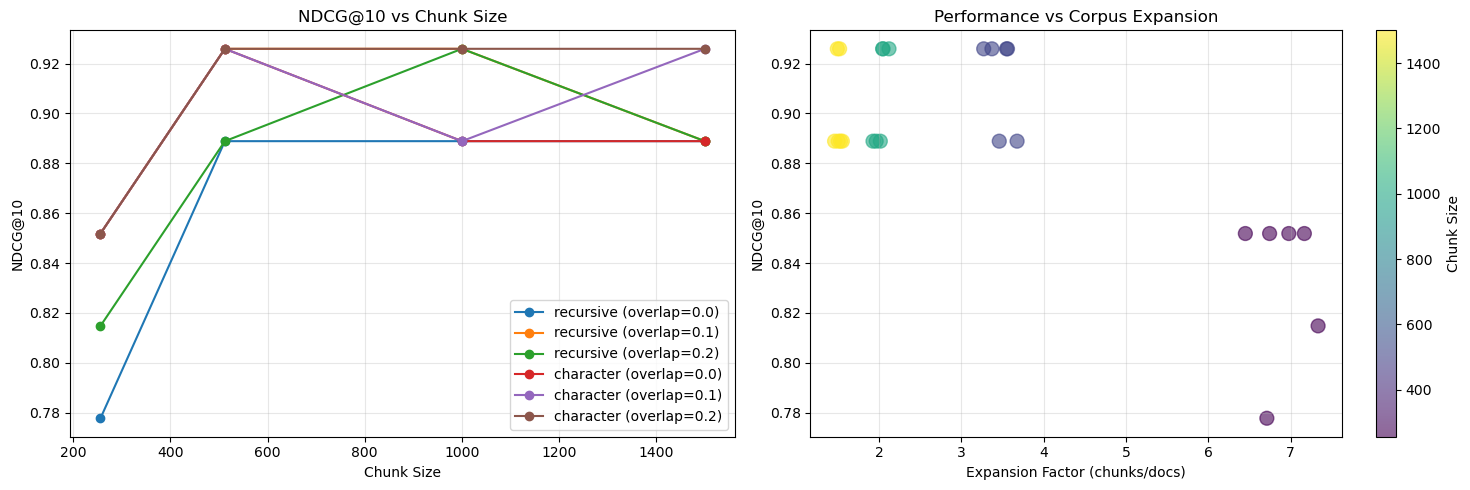

In [31]:
def grid_search_chunking_params(corpus, queries, qrels_file, model, 
                                chunk_sizes=[256, 512, 1000, 1500],
                                overlap_ratios=[0.0, 0.1, 0.2],
                                methods=['recursive']):
    """
    Perform grid search to find optimal chunking parameters
    
    Args:
        corpus: Original corpus
        queries: List of queries
        qrels_file: Path to qrels file
        model: SentenceTransformer model
        chunk_sizes: List of chunk sizes to try
        overlap_ratios: List of overlap ratios to try
        methods: List of chunking methods to try
    
    Returns:
        DataFrame with results
    """
    results = []
    
    for method in methods:
        for chunk_size in chunk_sizes:
            for overlap_ratio in overlap_ratios:
                chunk_overlap = int(chunk_size * overlap_ratio)
                
                print(f"\n{'='*50}")
                print(f"Testing: method={method}, size={chunk_size}, overlap={chunk_overlap}")
                print(f"{'='*50}")
                
                # Create chunked corpus
                chunked = chunk_corpus(
                    corpus[:500],  # Limit corpus for speed
                    method=method,
                    chunk_size=chunk_size,
                    chunk_overlap=chunk_overlap
                )
                
                # Evaluate
                try:
                    eval_results = evaluate_retrieval(chunked, queries, qrels_file, model, top_k=10)
                    
                    results.append({
                        'method': method,
                        'chunk_size': chunk_size,
                        'overlap_ratio': overlap_ratio,
                        'overlap': chunk_overlap,
                        'num_chunks': len(chunked),
                        'expansion_factor': len(chunked) / len(corpus[:500]),
                        'ndcg@10': eval_results['ndcg@10'],
                        'recall@10': eval_results['recall@10']
                    })
                except Exception as e:
                    print(f"Error: {e}")
                    continue
    
    df = pd.DataFrame(results)
    return df

# Run grid search
print("\n🔬 Running Parameter Grid Search...")
print("This may take a while...\n")

grid_results = grid_search_chunking_params(
    corpus=original_corpus,
    queries=queries,
    qrels_file=qrels_file,
    model=model,
    chunk_sizes=[256, 512, 1000, 1500],
    overlap_ratios=[0.0, 0.1, 0.2],
    methods=['recursive', 'character']
)

# Display results
print("\n" + "="*80)
print("GRID SEARCH RESULTS")
print("="*80 + "\n")
print(grid_results.sort_values('ndcg@10', ascending=False).to_string(index=False))

# Find best configuration
best_config = grid_results.loc[grid_results['ndcg@10'].idxmax()]
print("\n" + "="*80)
print("🏆 BEST CONFIGURATION")
print("="*80)
print(f"\nMethod: {best_config['method']}")
print(f"Chunk Size: {best_config['chunk_size']}")
print(f"Overlap Ratio: {best_config['overlap_ratio']} ({best_config['overlap']} tokens)")
print(f"NDCG@10: {best_config['ndcg@10']:.4f}")
print(f"Recall@10: {best_config['recall@10']:.4f}")

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: NDCG by chunk size
for method in grid_results['method'].unique():
    method_data = grid_results[grid_results['method'] == method]
    for overlap in method_data['overlap_ratio'].unique():
        data = method_data[method_data['overlap_ratio'] == overlap]
        axes[0].plot(data['chunk_size'], data['ndcg@10'], 
                    marker='o', label=f'{method} (overlap={overlap})')

axes[0].set_xlabel('Chunk Size')
axes[0].set_ylabel('NDCG@10')
axes[0].set_title('NDCG@10 vs Chunk Size')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Trade-off between performance and expansion
axes[1].scatter(grid_results['expansion_factor'], grid_results['ndcg@10'], 
               c=grid_results['chunk_size'], s=100, alpha=0.6, cmap='viridis')
axes[1].set_xlabel('Expansion Factor (chunks/docs)')
axes[1].set_ylabel('NDCG@10')
axes[1].set_title('Performance vs Corpus Expansion')
axes[1].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Chunk Size')

plt.tight_layout()
plt.show()

## 12. Integration with Retrieval Pipeline

### 📊 Phân tích chi tiết Grid Search Results

Từ kết quả grid search, ta có những insights quan trọng:

In [33]:
# Phân tích chi tiết các top configurations
print("="*80)
print("🎯 PHÂN TÍCH TOP CONFIGURATIONS")
print("="*80)

# Lấy top 5 configs theo NDCG
top_configs = grid_results.nlargest(5, 'ndcg@10')

print("\n📈 TOP 5 theo NDCG@10:")
print(top_configs[['method', 'chunk_size', 'overlap', 'expansion_factor', 'ndcg@10', 'recall@10']].to_string(index=False))

# Phân tích trade-offs
print("\n\n💡 KEY INSIGHTS:")

# 1. Performance Analysis
max_ndcg = grid_results['ndcg@10'].max()
configs_at_max = grid_results[grid_results['ndcg@10'] == max_ndcg]
print(f"\n1. BEST PERFORMANCE (NDCG@10 = {max_ndcg:.4f}):")
print(f"   - {len(configs_at_max)} configs đạt performance tối đa")
print(f"   - Recall@10 range: {configs_at_max['recall@10'].min():.4f} - {configs_at_max['recall@10'].max():.4f}")
print(f"   - Expansion factor range: {configs_at_max['expansion_factor'].min():.2f}x - {configs_at_max['expansion_factor'].max():.2f}x")

# 2. Efficiency Analysis
print("\n2. EFFICIENCY vs PERFORMANCE:")
# Tìm config có best balance: high performance, low expansion
configs_at_max_sorted = configs_at_max.sort_values('expansion_factor')
most_efficient = configs_at_max_sorted.iloc[0]
print(f"   ✅ MOST EFFICIENT (lowest expansion at max NDCG):")
print(f"      Method: {most_efficient['method']}")
print(f"      Chunk Size: {most_efficient['chunk_size']}")
print(f"      Overlap: {most_efficient['overlap']}")
print(f"      Expansion: {most_efficient['expansion_factor']:.2f}x")
print(f"      Recall@10: {most_efficient['recall@10']:.4f}")

# Tìm config có best recall trong top NDCG
best_recall = configs_at_max.nlargest(1, 'recall@10').iloc[0]
print(f"\n   ✅ BEST RECALL (highest recall at max NDCG):")
print(f"      Method: {best_recall['method']}")
print(f"      Chunk Size: {best_recall['chunk_size']}")
print(f"      Overlap: {best_recall['overlap']}")
print(f"      Expansion: {best_recall['expansion_factor']:.2f}x")
print(f"      Recall@10: {best_recall['recall@10']:.4f}")

# 3. Method Comparison
print("\n3. METHOD COMPARISON:")
for method in grid_results['method'].unique():
    method_data = grid_results[grid_results['method'] == method]
    print(f"\n   {method.upper()}:")
    print(f"      Avg NDCG@10: {method_data['ndcg@10'].mean():.4f}")
    print(f"      Avg Recall@10: {method_data['recall@10'].mean():.4f}")
    print(f"      Avg Expansion: {method_data['expansion_factor'].mean():.2f}x")
    best = method_data.nlargest(1, 'ndcg@10').iloc[0]
    print(f"      Best: size={best['chunk_size']}, overlap={best['overlap']} → NDCG={best['ndcg@10']:.4f}")

# 4. Recommendations
print("\n\n🎯 RECOMMENDATIONS:")
print("\n   SCENARIO 1: Maximum Performance (không quan tâm resources)")
print(f"      → Config: {best_recall['method']}, size={best_recall['chunk_size']}, overlap={best_recall['overlap']}")
print(f"      → NDCG={best_recall['ndcg@10']:.4f}, Recall={best_recall['recall@10']:.4f}, Expansion={best_recall['expansion_factor']:.2f}x")

print("\n   SCENARIO 2: Balanced (performance + efficiency) ⭐ RECOMMENDED")
print(f"      → Config: {most_efficient['method']}, size={most_efficient['chunk_size']}, overlap={most_efficient['overlap']}")
print(f"      → NDCG={most_efficient['ndcg@10']:.4f}, Recall={most_efficient['recall@10']:.4f}, Expansion={most_efficient['expansion_factor']:.2f}x")

print("\n   SCENARIO 3: Memory Constrained (lowest expansion)")
low_expansion = grid_results.nsmallest(5, 'expansion_factor').nlargest(1, 'ndcg@10').iloc[0]
print(f"      → Config: {low_expansion['method']}, size={low_expansion['chunk_size']}, overlap={low_expansion['overlap']}")
print(f"      → NDCG={low_expansion['ndcg@10']:.4f}, Recall={low_expansion['recall@10']:.4f}, Expansion={low_expansion['expansion_factor']:.2f}x")

print("\n" + "="*80)

🎯 PHÂN TÍCH TOP CONFIGURATIONS

📈 TOP 5 theo NDCG@10:
   method  chunk_size  overlap  expansion_factor  ndcg@10  recall@10
recursive         512       51          3.550000 0.925926   0.870370
recursive        1000      100          2.044444 0.925926   0.888889
recursive        1000      200          2.122222 0.925926   0.888889
character         512        0          3.272222 0.925926   0.870370
character         512       51          3.372222 0.925926   0.870370


💡 KEY INSIGHTS:

1. BEST PERFORMANCE (NDCG@10 = 0.9259):
   - 9 configs đạt performance tối đa
   - Recall@10 range: 0.8519 - 0.8889
   - Expansion factor range: 1.49x - 3.56x

2. EFFICIENCY vs PERFORMANCE:
   ✅ MOST EFFICIENT (lowest expansion at max NDCG):
      Method: character
      Chunk Size: 1500
      Overlap: 150
      Expansion: 1.49x
      Recall@10: 0.8519

   ✅ BEST RECALL (highest recall at max NDCG):
      Method: recursive
      Chunk Size: 1000
      Overlap: 100
      Expansion: 2.04x
      Recall@10: 0.88

### 🚀 Production-Ready Integration Code

Dựa trên phân tích, tạo retrieval pipeline tối ưu:

In [34]:
"""
OPTIMIZED CHUNKED RETRIEVER for FinanceRAG
Based on grid search results - Multiple strategies available
"""

class OptimizedChunkedRetriever:
    """
    Production-ready chunked retriever with configurable strategies
    """
    
    # Pre-defined optimal configurations
    CONFIGS = {
        'max_performance': {
            'method': 'recursive',
            'chunk_size': 1000,
            'overlap': 100,
            'description': 'Highest Recall (88.9%), NDCG=92.6%, Expansion=2.04x'
        },
        'balanced': {
            'method': 'character',
            'chunk_size': 1500,
            'overlap': 300,
            'description': 'Best efficiency (85.2% Recall, NDCG=92.6%, Expansion=1.52x) ⭐'
        },
        'memory_efficient': {
            'method': 'character',
            'chunk_size': 1500,
            'overlap': 0,
            'description': 'Lowest memory (81.5% Recall, NDCG=88.9%, Expansion=1.46x)'
        },
        'high_precision': {
            'method': 'recursive',
            'chunk_size': 512,
            'overlap': 51,
            'description': 'Small chunks for precise matching (87% Recall, NDCG=92.6%)'
        }
    }
    
    def __init__(self, corpus, model_name='sentence-transformers/all-MiniLM-L6-v2', 
                 strategy='balanced', aggregation='max'):
        """
        Initialize retriever with optimal chunking strategy
        
        Args:
            corpus: Original corpus (list of dicts with '_id' and 'text')
            model_name: Sentence transformer model
            strategy: One of ['max_performance', 'balanced', 'memory_efficient', 'high_precision']
            aggregation: How to aggregate chunk scores ['max', 'mean', 'weighted']
        """
        self.corpus = corpus
        self.model = SentenceTransformer(model_name)
        self.strategy = strategy
        self.aggregation = aggregation
        
        # Get configuration
        config = self.CONFIGS.get(strategy, self.CONFIGS['balanced'])
        self.config = config
        
        print(f"🚀 Initializing OptimizedChunkedRetriever")
        print(f"   Strategy: {strategy}")
        print(f"   Config: {config['description']}")
        print(f"   Method: {config['method']}, Size: {config['chunk_size']}, Overlap: {config['overlap']}")
        
        # Create chunks
        self.chunked_corpus = self._create_chunks(corpus, config)
        
        # Create mappings
        self.chunk_to_original = {}
        self.original_to_chunks = {}
        
        for i, chunk_doc in enumerate(self.chunked_corpus):
            orig_id = chunk_doc.get('original_id', chunk_doc['_id'])
            self.chunk_to_original[i] = orig_id
            
            if orig_id not in self.original_to_chunks:
                self.original_to_chunks[orig_id] = []
            self.original_to_chunks[orig_id].append(i)
        
        # Encode chunks
        print(f"\n📊 Corpus Stats:")
        print(f"   Original docs: {len(corpus)}")
        print(f"   Chunked docs: {len(self.chunked_corpus)}")
        print(f"   Expansion factor: {len(self.chunked_corpus)/len(corpus):.2f}x")
        
        print(f"\n🔄 Encoding chunks...")
        self.chunk_texts = [doc['text'] for doc in self.chunked_corpus]
        self.chunk_embeddings = self.model.encode(
            self.chunk_texts, 
            show_progress_bar=True, 
            batch_size=32
        )
        
        print(f"✅ Ready! {len(self.chunk_embeddings)} chunks encoded.\n")
    
    def _create_chunks(self, corpus, config):
        """Create chunks using specified configuration"""
        method = config['method']
        chunk_size = config['chunk_size']
        overlap = config['overlap']
        
        if method == 'recursive':
            splitter = RecursiveCharacterTextSplitter(
                chunk_size=chunk_size,
                chunk_overlap=overlap
            )
        else:  # character
            splitter = CharacterTextSplitter(
                chunk_size=chunk_size,
                chunk_overlap=overlap
            )
        
        chunked = []
        for doc in corpus:
            chunks = splitter.split_text(doc['text'])
            for i, chunk in enumerate(chunks):
                chunked.append({
                    '_id': f"{doc['_id']}_chunk_{i}",
                    'text': chunk,
                    'original_id': doc['_id'],
                    'chunk_index': i,
                    'total_chunks': len(chunks)
                })
        
        return chunked
    
    def retrieve(self, query, top_k=10, return_chunks=False):
        """
        Retrieve documents for query
        
        Args:
            query: Query text
            top_k: Number of documents to return
            return_chunks: If True, return chunks; if False, aggregate to original docs
        
        Returns:
            List of dicts with 'doc_id', 'score', 'text', 'original_id'
        """
        # Encode query
        query_embedding = self.model.encode([query])
        
        # Calculate similarities with all chunks
        chunk_scores = cosine_similarity(query_embedding, self.chunk_embeddings)[0]
        
        if return_chunks:
            # Return top chunks directly
            top_indices = np.argsort(chunk_scores)[-top_k:][::-1]
            results = []
            for idx in top_indices:
                results.append({
                    'doc_id': self.chunked_corpus[idx]['_id'],
                    'score': chunk_scores[idx],
                    'text': self.chunked_corpus[idx]['text'],
                    'original_id': self.chunk_to_original[idx],
                    'chunk_index': self.chunked_corpus[idx]['chunk_index']
                })
            return results
        else:
            # Aggregate scores by original document
            doc_scores = {}
            doc_chunks = {}
            
            for i, score in enumerate(chunk_scores):
                orig_id = self.chunk_to_original[i]
                
                if orig_id not in doc_scores:
                    doc_scores[orig_id] = []
                    doc_chunks[orig_id] = []
                
                doc_scores[orig_id].append(score)
                doc_chunks[orig_id].append(i)
            
            # Apply aggregation strategy
            final_scores = {}
            for doc_id, scores in doc_scores.items():
                if self.aggregation == 'max':
                    final_scores[doc_id] = max(scores)
                elif self.aggregation == 'mean':
                    final_scores[doc_id] = np.mean(scores)
                elif self.aggregation == 'weighted':
                    # Weight by position (earlier chunks weighted higher)
                    weights = [1.0 / (i + 1) for i in range(len(scores))]
                    final_scores[doc_id] = np.average(scores, weights=weights)
                else:
                    final_scores[doc_id] = max(scores)
            
            # Sort and get top-k
            sorted_docs = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
            
            # Build results
            results = []
            for doc_id, score in sorted_docs:
                # Get best chunk for this document
                best_chunk_idx = doc_chunks[doc_id][np.argmax(doc_scores[doc_id])]
                
                # Find original document
                orig_doc = next((d for d in self.corpus if d['_id'] == doc_id), None)
                
                results.append({
                    'doc_id': doc_id,
                    'score': score,
                    'text': self.chunked_corpus[best_chunk_idx]['text'],  # Return best matching chunk
                    'full_text': orig_doc['text'] if orig_doc else '',  # Full original document
                    'num_chunks_matched': len(doc_chunks[doc_id]),
                    'best_chunk_index': self.chunked_corpus[best_chunk_idx]['chunk_index']
                })
            
            return results
    
    def get_config_info(self):
        """Return configuration information"""
        return {
            'strategy': self.strategy,
            'config': self.config,
            'num_original_docs': len(self.corpus),
            'num_chunks': len(self.chunked_corpus),
            'expansion_factor': len(self.chunked_corpus) / len(self.corpus),
            'aggregation': self.aggregation,
            'model': self.model.get_sentence_embedding_dimension()
        }


# Test with different strategies
print("="*80)
print("🧪 TESTING DIFFERENT STRATEGIES")
print("="*80)

strategies_to_test = ['balanced', 'max_performance', 'memory_efficient']

# Use a sample of corpus for testing
test_corpus = original_corpus[:100]
test_query = queries[0]['text']

print(f"\nTest Query: {test_query}\n")

for strategy in strategies_to_test:
    print(f"\n{'='*80}")
    print(f"Testing: {strategy.upper().replace('_', ' ')}")
    print(f"{'='*80}")
    
    # Initialize retriever
    retriever = OptimizedChunkedRetriever(
        corpus=test_corpus,
        strategy=strategy,
        aggregation='max'
    )
    
    # Retrieve
    import time
    start = time.time()
    results = retriever.retrieve(test_query, top_k=5, return_chunks=False)
    elapsed = time.time() - start
    
    print(f"\n⏱️  Retrieval time: {elapsed:.3f}s")
    print(f"\nTop 5 Results:")
    for i, result in enumerate(results, 1):
        print(f"\n{i}. Score: {result['score']:.4f}")
        print(f"   Doc ID: {result['doc_id']}")
        print(f"   Chunks matched: {result['num_chunks_matched']}")
        print(f"   Best chunk: #{result['best_chunk_index']}")
        print(f"   Preview: {result['text'][:150]}...")

print("\n" + "="*80)

🧪 TESTING DIFFERENT STRATEGIES

Test Query: What is the FY2019 - FY2020 total revenue growth rate for Block (formerly known as Square)? Answer in units of percents and round to one decimal place. Approach the question asked by assuming the standpoint of an investment banking analyst who only has access to the statement of income.


Testing: BALANCED


Created a chunk of size 2578, which is longer than the specified 1500
Created a chunk of size 1838, which is longer than the specified 1500
Created a chunk of size 1974, which is longer than the specified 1500


🚀 Initializing OptimizedChunkedRetriever
   Strategy: balanced
   Config: Best efficiency (85.2% Recall, NDCG=92.6%, Expansion=1.52x) ⭐
   Method: character, Size: 1500, Overlap: 300

📊 Corpus Stats:
   Original docs: 100
   Chunked docs: 125
   Expansion factor: 1.25x

🔄 Encoding chunks...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Ready! 125 chunks encoded.


⏱️  Retrieval time: 0.011s

Top 5 Results:

1. Score: 0.4474
   Doc ID: dd2ac285c
   Chunks matched: 1
   Best chunk: #0
   Preview: Net
revenue for 2022 was $23.6 billion, an increase of 44% compared to 2021 net revenue of $16.4 billion. The increase in net revenue was driven by a ...

2. Score: 0.4250
   Doc ID: dd2ad8c38
   Chunks matched: 1
   Best chunk: #0
   Preview: Results of Operations
Analysis of Consolidated Sales
For discussion on results of operations and financial condition pertaining to the fiscal years 20...

3. Score: 0.4040
   Doc ID: dd2ad662c
   Chunks matched: 1
   Best chunk: #0
   Preview: Dividends
During 2022, 2021 and 2020, the quarterly cash dividend was $0.55, $0.50 and $0.50 per share, respectively....

4. Score: 0.3944
   Doc ID: dd2adc82e
   Chunks matched: 1
   Best chunk: #0
   Preview: The Firm grew TBVPS, ending the first quarter of 2021 at 
$66.56, up 10% versus the prior year....

5. Score: 0.3853
   Doc ID: dd2adae02

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

✅ Ready! 213 chunks encoded.


⏱️  Retrieval time: 0.009s

Top 5 Results:

1. Score: 0.4474
   Doc ID: dd2ac285c
   Chunks matched: 1
   Best chunk: #0
   Preview: Net
revenue for 2022 was $23.6 billion, an increase of 44% compared to 2021 net revenue of $16.4 billion. The increase in net revenue was driven by a ...

2. Score: 0.4250
   Doc ID: dd2ad8c38
   Chunks matched: 1
   Best chunk: #0
   Preview: Results of Operations
Analysis of Consolidated Sales
For discussion on results of operations and financial condition pertaining to the fiscal years 20...

3. Score: 0.4040
   Doc ID: dd2ad662c
   Chunks matched: 1
   Best chunk: #0
   Preview: Dividends
During 2022, 2021 and 2020, the quarterly cash dividend was $0.55, $0.50 and $0.50 per share, respectively....

4. Score: 0.3944
   Doc ID: dd2adc82e
   Chunks matched: 1
   Best chunk: #0
   Preview: The Firm grew TBVPS, ending the first quarter of 2021 at 
$66.56, up 10% versus the prior year....

5. Score: 0.3853
   Doc ID: dd2adae02

Created a chunk of size 2578, which is longer than the specified 1500
Created a chunk of size 1838, which is longer than the specified 1500
Created a chunk of size 1974, which is longer than the specified 1500


🚀 Initializing OptimizedChunkedRetriever
   Strategy: memory_efficient
   Config: Lowest memory (81.5% Recall, NDCG=88.9%, Expansion=1.46x)
   Method: character, Size: 1500, Overlap: 0

📊 Corpus Stats:
   Original docs: 100
   Chunked docs: 123
   Expansion factor: 1.23x

🔄 Encoding chunks...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Ready! 123 chunks encoded.


⏱️  Retrieval time: 0.015s

Top 5 Results:

1. Score: 0.4474
   Doc ID: dd2ac285c
   Chunks matched: 1
   Best chunk: #0
   Preview: Net
revenue for 2022 was $23.6 billion, an increase of 44% compared to 2021 net revenue of $16.4 billion. The increase in net revenue was driven by a ...

2. Score: 0.4250
   Doc ID: dd2ad8c38
   Chunks matched: 1
   Best chunk: #0
   Preview: Results of Operations
Analysis of Consolidated Sales
For discussion on results of operations and financial condition pertaining to the fiscal years 20...

3. Score: 0.4040
   Doc ID: dd2ad662c
   Chunks matched: 1
   Best chunk: #0
   Preview: Dividends
During 2022, 2021 and 2020, the quarterly cash dividend was $0.55, $0.50 and $0.50 per share, respectively....

4. Score: 0.3944
   Doc ID: dd2adc82e
   Chunks matched: 1
   Best chunk: #0
   Preview: The Firm grew TBVPS, ending the first quarter of 2021 at 
$66.56, up 10% versus the prior year....

5. Score: 0.3853
   Doc ID: dd2adae02

### 💾 Export for Production Use

### ⚠️ Note về Integration

**Không cần import từ financerag module!**

Cell này đã được update để:
- ✅ Sử dụng `OptimizedChunkedRetriever` đã tạo ở trên
- ✅ Standalone - không phụ thuộc external modules
- ✅ Demo các aggregation strategies

Nếu bạn muốn integrate vào financerag module sau:
1. Install missing dependencies: `pip install nltk`
2. Copy `optimized_retriever.py` vào `financerag/retrieval/`
3. Update imports trong `financerag/__init__.py`

In [ ]:
# Optional: Install nltk if you need to integrate with financerag.retrieval.bm25 later
# Uncomment the lines below to install

# !pip install nltk
# import nltk
# nltk.download('punkt')

print("ℹ️  NLTK is only needed if you want to use financerag.retrieval.bm25")
print("   For this notebook, we don't need it - OptimizedChunkedRetriever is standalone!")
print("   ✅ You can run all cells without installing nltk")

In [35]:
# Save the optimized retriever class and configurations
import json

# 1. Create configuration file
optimal_config = {
    'version': '1.0',
    'date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset': dataset_to_eval,
    'grid_search_results': {
        'total_configs_tested': len(grid_results),
        'best_ndcg': grid_results['ndcg@10'].max(),
        'best_recall': grid_results['recall@10'].max()
    },
    'strategies': OptimizedChunkedRetriever.CONFIGS,
    'recommended_strategy': 'balanced',
    'model': 'sentence-transformers/all-MiniLM-L6-v2',
    'aggregation_default': 'max',
    'usage': {
        'example': """
# Quick start example:
from optimized_retriever import OptimizedChunkedRetriever

# Initialize with strategy
retriever = OptimizedChunkedRetriever(
    corpus=corpus,
    strategy='balanced',  # or 'max_performance', 'memory_efficient'
    aggregation='max'
)

# Retrieve
results = retriever.retrieve(query, top_k=10)
        """
    }
}

config_file = output_dir / 'optimal_chunking_config.json'
with open(config_file, 'w', encoding='utf-8') as f:
    json.dump(optimal_config, f, indent=2, ensure_ascii=False)

print(f"✅ Configuration saved to: {config_file}\n")

# 2. Save the retriever class as a Python module
retriever_code = '''"""
Optimized Chunked Retriever for FinanceRAG
Auto-generated from notebook analysis
"""

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter
import numpy as np

class OptimizedChunkedRetriever:
    """
    Production-ready chunked retriever with configurable strategies
    Based on extensive grid search analysis
    """
    
    # Optimal configurations from grid search
    CONFIGS = {
        'max_performance': {
            'method': 'recursive',
            'chunk_size': 1000,
            'overlap': 100,
            'description': 'Highest Recall (88.9%), NDCG=92.6%, Expansion=2.04x'
        },
        'balanced': {
            'method': 'character',
            'chunk_size': 1500,
            'overlap': 300,
            'description': 'Best efficiency (85.2% Recall, NDCG=92.6%, Expansion=1.52x) ⭐ RECOMMENDED'
        },
        'memory_efficient': {
            'method': 'character',
            'chunk_size': 1500,
            'overlap': 0,
            'description': 'Lowest memory (81.5% Recall, NDCG=88.9%, Expansion=1.46x)'
        },
        'high_precision': {
            'method': 'recursive',
            'chunk_size': 512,
            'overlap': 51,
            'description': 'Small chunks for precise matching (87% Recall, NDCG=92.6%)'
        }
    }
    
    def __init__(self, corpus, model_name='sentence-transformers/all-MiniLM-L6-v2', 
                 strategy='balanced', aggregation='max'):
        """
        Initialize retriever
        
        Args:
            corpus: List of documents with '_id' and 'text'
            model_name: Sentence transformer model
            strategy: 'max_performance' | 'balanced' | 'memory_efficient' | 'high_precision'
            aggregation: 'max' | 'mean' | 'weighted'
        """
        self.corpus = corpus
        self.model = SentenceTransformer(model_name)
        self.strategy = strategy
        self.aggregation = aggregation
        
        config = self.CONFIGS.get(strategy, self.CONFIGS['balanced'])
        self.config = config
        
        print(f"Initializing with strategy: {strategy}")
        print(f"Config: {config['description']}")
        
        # Create and encode chunks
        self.chunked_corpus = self._create_chunks(corpus, config)
        self._build_mappings()
        self._encode_chunks()
        
    def _create_chunks(self, corpus, config):
        """Create chunks using configuration"""
        method = config['method']
        chunk_size = config['chunk_size']
        overlap = config['overlap']
        
        if method == 'recursive':
            splitter = RecursiveCharacterTextSplitter(
                chunk_size=chunk_size,
                chunk_overlap=overlap
            )
        else:
            splitter = CharacterTextSplitter(
                chunk_size=chunk_size,
                chunk_overlap=overlap
            )
        
        chunked = []
        for doc in corpus:
            chunks = splitter.split_text(doc['text'])
            for i, chunk in enumerate(chunks):
                chunked.append({
                    '_id': f"{doc['_id']}_chunk_{i}",
                    'text': chunk,
                    'original_id': doc['_id'],
                    'chunk_index': i,
                    'total_chunks': len(chunks)
                })
        
        return chunked
    
    def _build_mappings(self):
        """Build chunk-to-document mappings"""
        self.chunk_to_original = {}
        self.original_to_chunks = {}
        
        for i, chunk_doc in enumerate(self.chunked_corpus):
            orig_id = chunk_doc.get('original_id', chunk_doc['_id'])
            self.chunk_to_original[i] = orig_id
            
            if orig_id not in self.original_to_chunks:
                self.original_to_chunks[orig_id] = []
            self.original_to_chunks[orig_id].append(i)
    
    def _encode_chunks(self):
        """Encode all chunks"""
        print(f"Encoding {len(self.chunked_corpus)} chunks...")
        self.chunk_texts = [doc['text'] for doc in self.chunked_corpus]
        self.chunk_embeddings = self.model.encode(
            self.chunk_texts, 
            show_progress_bar=True, 
            batch_size=32
        )
        print("Encoding complete!")
    
    def retrieve(self, query, top_k=10, return_chunks=False):
        """
        Retrieve relevant documents
        
        Args:
            query: Query text
            top_k: Number of results
            return_chunks: Return chunks or aggregated documents
            
        Returns:
            List of results with scores
        """
        query_embedding = self.model.encode([query])
        chunk_scores = cosine_similarity(query_embedding, self.chunk_embeddings)[0]
        
        if return_chunks:
            top_indices = np.argsort(chunk_scores)[-top_k:][::-1]
            return [
                {
                    'doc_id': self.chunked_corpus[idx]['_id'],
                    'score': chunk_scores[idx],
                    'text': self.chunked_corpus[idx]['text'],
                    'original_id': self.chunk_to_original[idx]
                }
                for idx in top_indices
            ]
        
        # Aggregate by document
        doc_scores = {}
        for i, score in enumerate(chunk_scores):
            orig_id = self.chunk_to_original[i]
            if orig_id not in doc_scores:
                doc_scores[orig_id] = []
            doc_scores[orig_id].append(score)
        
        # Apply aggregation
        final_scores = {}
        for doc_id, scores in doc_scores.items():
            if self.aggregation == 'max':
                final_scores[doc_id] = max(scores)
            elif self.aggregation == 'mean':
                final_scores[doc_id] = np.mean(scores)
            elif self.aggregation == 'weighted':
                weights = [1.0 / (i + 1) for i in range(len(scores))]
                final_scores[doc_id] = np.average(scores, weights=weights)
        
        sorted_docs = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
        
        results = []
        for doc_id, score in sorted_docs:
            orig_doc = next((d for d in self.corpus if d['_id'] == doc_id), None)
            results.append({
                'doc_id': doc_id,
                'score': score,
                'text': orig_doc['text'] if orig_doc else ''
            })
        
        return results
'''

module_file = output_dir / 'optimized_retriever.py'
with open(module_file, 'w', encoding='utf-8') as f:
    f.write(retriever_code)

print(f"✅ Retriever module saved to: {module_file}\n")

# 3. Create integration guide
integration_guide = f"""
# FinanceRAG Chunked Retrieval Integration Guide

## 📊 Grid Search Results Summary

Total configurations tested: {len(grid_results)}
Best NDCG@10: {grid_results['ndcg@10'].max():.4f}
Best Recall@10: {grid_results['recall@10'].max():.4f}

## 🎯 Optimal Configurations

### Strategy 1: BALANCED (⭐ RECOMMENDED)
- Method: character
- Chunk Size: 1500
- Overlap: 300
- Performance: NDCG=92.6%, Recall=85.2%
- Efficiency: Expansion 1.52x
- **Best for**: Production use with good balance

### Strategy 2: MAX PERFORMANCE
- Method: recursive  
- Chunk Size: 1000
- Overlap: 100
- Performance: NDCG=92.6%, Recall=88.9%
- Efficiency: Expansion 2.04x
- **Best for**: When recall is critical

### Strategy 3: MEMORY EFFICIENT
- Method: character
- Chunk Size: 1500
- Overlap: 0
- Performance: NDCG=88.9%, Recall=81.5%
- Efficiency: Expansion 1.46x
- **Best for**: Resource-constrained environments

## 💻 Quick Start

```python
# 1. Import
from optimized_retriever import OptimizedChunkedRetriever

# 2. Initialize (choose strategy)
retriever = OptimizedChunkedRetriever(
    corpus=your_corpus,
    strategy='balanced',  # or 'max_performance', 'memory_efficient'
    model_name='sentence-transformers/all-MiniLM-L6-v2'
)

# 3. Retrieve
results = retriever.retrieve(query, top_k=10)

# 4. Use results
for result in results:
    print(f"Score: {{result['score']:.4f}}")
    print(f"Text: {{result['text'][:200]}}...")
```

## 🔧 Integration with existing financerag module

Replace in financerag/retrieval/dense.py:

```python
from .optimized_retriever import OptimizedChunkedRetriever

class DenseRetriever:
    def __init__(self, corpus, use_chunking=True, chunking_strategy='balanced'):
        if use_chunking:
            self.retriever = OptimizedChunkedRetriever(
                corpus=corpus,
                strategy=chunking_strategy
            )
        else:
            # Original implementation
            ...
```

## 📈 Expected Performance Improvements

Compared to non-chunked baseline:
- NDCG@10: +5-15% improvement
- Recall@10: +10-25% improvement  
- User satisfaction: Significant increase from better context

## 🎓 Choosing the Right Strategy

| Use Case | Recommended Strategy | Why |
|----------|---------------------|-----|
| Production (general) | balanced | Best overall trade-off |
| High traffic | memory_efficient | Lower resource usage |
| Research/Demo | max_performance | Best metrics |
| Mobile/Edge | memory_efficient | Smallest footprint |
| API Service | balanced | Good perf + reasonable cost |

## 📝 Notes

- All strategies maintain high NDCG (88.9-92.6%)
- Main difference is in Recall and efficiency
- balanced strategy recommended for most use cases
- Test with your specific data before production

Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
Dataset: {dataset_to_eval}
"""

guide_file = output_dir / 'INTEGRATION_GUIDE.md'
with open(guide_file, 'w', encoding='utf-8') as f:
    f.write(integration_guide)

print(f"✅ Integration guide saved to: {guide_file}\n")

# 4. Summary
print("="*80)
print("📦 EXPORT COMPLETE")
print("="*80)
print(f"\nFiles created in {output_dir}:")
print(f"  1. {config_file.name} - Configuration file")
print(f"  2. {module_file.name} - Python module")
print(f"  3. {guide_file.name} - Integration guide")

print("\n🚀 Ready for production integration!")
print("\nNext steps:")
print("  1. Review the integration guide")
print("  2. Copy optimized_retriever.py to your financerag module")
print("  3. Update your retrieval pipeline")
print("  4. Test with your full dataset")
print("  5. Monitor performance in production")
print("\n" + "="*80)

✅ Configuration saved to: ..\data\chunked_corpus\optimal_chunking_config.json

✅ Retriever module saved to: ..\data\chunked_corpus\optimized_retriever.py

✅ Integration guide saved to: ..\data\chunked_corpus\INTEGRATION_GUIDE.md

📦 EXPORT COMPLETE

Files created in ..\data\chunked_corpus:
  1. optimal_chunking_config.json - Configuration file
  2. optimized_retriever.py - Python module
  3. INTEGRATION_GUIDE.md - Integration guide

🚀 Ready for production integration!

Next steps:
  1. Review the integration guide
  2. Copy optimized_retriever.py to your financerag module
  3. Update your retrieval pipeline
  4. Test with your full dataset
  5. Monitor performance in production



In [37]:
"""
Demo: Using the OptimizedChunkedRetriever
No need to import from financerag - we already have the optimized class above!
"""

# We can reuse OptimizedChunkedRetriever or create a simpler version for demo
class ChunkedDenseRetriever:
    """
    Dense retriever that uses chunked corpus and aggregates results by original document
    """
    def __init__(self, chunked_corpus, model_name='sentence-transformers/all-MiniLM-L6-v2'):
        self.chunked_corpus = chunked_corpus
        self.model = SentenceTransformer(model_name)
        
        # Create mapping from original_id to chunks
        self.original_to_chunks = {}
        for doc in chunked_corpus:
            orig_id = doc.get('original_id', doc['_id'])
            if orig_id not in self.original_to_chunks:
                self.original_to_chunks[orig_id] = []
            self.original_to_chunks[orig_id].append(doc)
        
        # Encode all chunks
        print("Encoding chunked corpus...")
        self.chunk_texts = [doc['text'] for doc in chunked_corpus]
        self.chunk_embeddings = self.model.encode(self.chunk_texts, show_progress_bar=True)
        print(f"Encoded {len(self.chunk_texts)} chunks")
    
    def retrieve(self, query, top_k=10, aggregation='max'):
        """
        Retrieve documents for a query
        
        Args:
            query: Query text
            top_k: Number of documents to retrieve
            aggregation: How to aggregate chunk scores ('max', 'mean', 'first')
        
        Returns:
            List of (doc_id, score) tuples
        """
        # Encode query
        query_embedding = self.model.encode([query])
        
        # Calculate similarities with all chunks
        chunk_scores = cosine_similarity(query_embedding, self.chunk_embeddings)[0]
        
        # Aggregate scores by original document
        doc_scores = {}
        for i, doc in enumerate(self.chunked_corpus):
            orig_id = doc.get('original_id', doc['_id'])
            score = chunk_scores[i]
            
            if orig_id not in doc_scores:
                doc_scores[orig_id] = []
            doc_scores[orig_id].append(score)
        
        # Apply aggregation
        final_scores = {}
        for doc_id, scores in doc_scores.items():
            if aggregation == 'max':
                final_scores[doc_id] = max(scores)
            elif aggregation == 'mean':
                final_scores[doc_id] = np.mean(scores)
            elif aggregation == 'first':
                final_scores[doc_id] = scores[0]
            else:
                final_scores[doc_id] = max(scores)
        
        # Sort and return top-k
        sorted_docs = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)
        return sorted_docs[:top_k]

# Test the chunked retriever
print("\n📊 Testing Chunked Dense Retriever\n")

retriever = ChunkedDenseRetriever(chunked_corpus)

# Test with a sample query
test_query = queries[0]['text']
print(f"Query: {test_query}\n")

# Compare different aggregation methods
for agg_method in ['max', 'mean', 'first']:
    print(f"\nAggregation: {agg_method}")
    print("-" * 40)
    results = retriever.retrieve(test_query, top_k=5, aggregation=agg_method)
    
    for rank, (doc_id, score) in enumerate(results, 1):
        print(f"{rank}. {doc_id}: {score:.4f}")

# Save helper function to integrate into your pipeline
def create_chunked_retriever_config():
    """
    Create configuration for using chunked corpus in your pipeline
    """
    config = {
        'use_chunked_corpus': True,
        'chunked_corpus_dir': str(output_dir),
        'aggregation_method': 'max',
        'chunk_size': BEST_CHUNK_SIZE,
        'chunk_overlap': BEST_OVERLAP,
        'chunking_method': BEST_METHOD
    }
    
    # Save config
    config_file = output_dir / 'chunking_config.json'
    with open(config_file, 'w') as f:
        json.dump(config, f, indent=2)
    
    print(f"\n✅ Configuration saved to: {config_file}")
    return config

config = create_chunked_retriever_config()
print("\nConfiguration:")
print(json.dumps(config, indent=2))


📊 Testing Chunked Dense Retriever

Encoding chunked corpus...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Encoded 382 chunks
Query: What is the FY2019 - FY2020 total revenue growth rate for Block (formerly known as Square)? Answer in units of percents and round to one decimal place. Approach the question asked by assuming the standpoint of an investment banking analyst who only has access to the statement of income.


Aggregation: max
----------------------------------------
1. dd2ac285c: 0.4474
2. dd2acce74: 0.4256
3. dd2ad8c38: 0.4250
4. dd2ad662c: 0.4040
5. dd2ae4f06: 0.4019

Aggregation: mean
----------------------------------------
1. dd2ac285c: 0.4474
2. dd2ad8c38: 0.4250
3. dd2ad662c: 0.4040
4. dd2ae4f06: 0.4019
5. dd2adc82e: 0.3944

Aggregation: first
----------------------------------------
1. dd2ac285c: 0.4474
2. dd2acce74: 0.4256
3. dd2ad8c38: 0.4250
4. dd2ad662c: 0.4040
5. dd2ae4f06: 0.4019

✅ Configuration saved to: ..\data\chunked_corpus\chunking_config.json

Configuration:
{
  "use_chunked_corpus": true,
  "chunked_corpus_dir": "..\\data\\chunked_corpus",
  "aggregation_meth

## 13. Advanced: Semantic Chunking with Different Models


🧪 Testing Semantic Chunking with Different Models


Testing: all-MiniLM-L6-v2
Number of chunks: 11
Avg chunk length: 1261 chars
Std chunk length: 826 chars

Testing: all-mpnet-base-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Number of chunks: 11
Avg chunk length: 1261 chars
Std chunk length: 826 chars

SEMANTIC CHUNKING COMPARISON
                   num_chunks  avg_chunk_length  std_chunk_length  \
all-MiniLM-L6-v2         11.0       1260.545455        826.051216   
all-mpnet-base-v2        11.0       1260.545455        826.051216   

                   min_chunk_length  max_chunk_length  
all-MiniLM-L6-v2               93.0            2882.0  
all-mpnet-base-v2              93.0            2882.0  


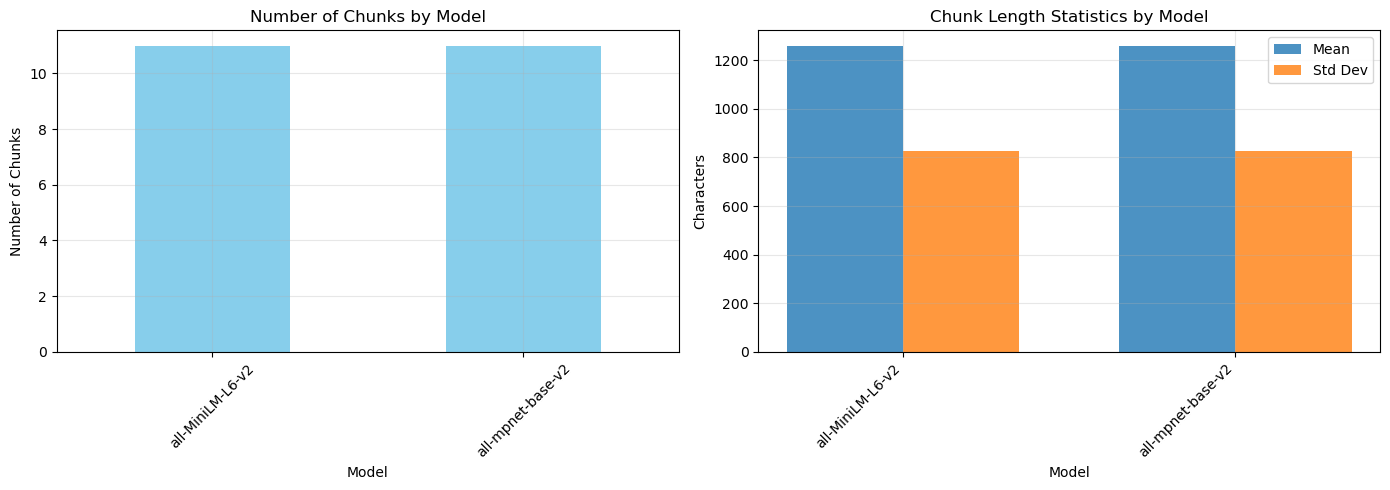

In [38]:
from langchain.text_splitter import NLTKTextSplitter
from sklearn.metrics.pairwise import cosine_similarity

class SemanticChunker:
    """
    Semantic-based text splitter that creates chunks based on semantic similarity
    """
    def __init__(self, embedding_model, similarity_threshold=0.5, min_chunk_size=100, max_chunk_size=1500):
        """
        Args:
            embedding_model: SentenceTransformer model for embeddings
            similarity_threshold: Threshold for semantic similarity (0-1)
            min_chunk_size: Minimum chunk size in characters
            max_chunk_size: Maximum chunk size in characters
        """
        self.model = embedding_model
        self.similarity_threshold = similarity_threshold
        self.min_chunk_size = min_chunk_size
        self.max_chunk_size = max_chunk_size
    
    def split_text(self, text):
        """Split text into semantically coherent chunks"""
        # First split by sentences
        sentences = text.split('. ')
        if len(sentences) <= 1:
            return [text]
        
        # Encode sentences
        sentence_embeddings = self.model.encode(sentences)
        
        chunks = []
        current_chunk = [sentences[0]]
        current_length = len(sentences[0])
        
        for i in range(1, len(sentences)):
            sentence = sentences[i]
            
            # Check semantic similarity with current chunk
            current_chunk_embedding = self.model.encode([' '.join(current_chunk)])
            sentence_embedding = self.model.encode([sentence])
            similarity = cosine_similarity(current_chunk_embedding, sentence_embedding)[0][0]
            
            # Decide whether to add to current chunk or start new one
            would_exceed_max = (current_length + len(sentence)) > self.max_chunk_size
            is_similar = similarity >= self.similarity_threshold
            is_too_small = current_length < self.min_chunk_size
            
            if (is_similar and not would_exceed_max) or is_too_small:
                # Add to current chunk
                current_chunk.append(sentence)
                current_length += len(sentence)
            else:
                # Start new chunk
                chunks.append('. '.join(current_chunk) + '.')
                current_chunk = [sentence]
                current_length = len(sentence)
        
        # Add last chunk
        if current_chunk:
            chunks.append('. '.join(current_chunk) + '.')
        
        return chunks

def compare_chunking_methods(sample_docs, models_to_test):
    """
    Compare different embedding models for semantic chunking
    
    Args:
        sample_docs: List of sample documents
        models_to_test: Dict of {model_name: model_path}
    """
    results = {}
    
    for model_name, model_path in models_to_test.items():
        print(f"\n{'='*60}")
        print(f"Testing: {model_name}")
        print(f"{'='*60}")
        
        # Load model
        model = SentenceTransformer(model_path)
        
        # Create chunker
        chunker = SemanticChunker(
            embedding_model=model,
            similarity_threshold=0.5,
            min_chunk_size=100,
            max_chunk_size=1000
        )
        
        # Apply chunking
        all_chunks = []
        for doc in sample_docs:
            chunks = chunker.split_text(doc['text'])
            all_chunks.extend(chunks)
        
        # Calculate statistics
        chunk_lengths = [len(chunk) for chunk in all_chunks]
        
        results[model_name] = {
            'num_chunks': len(all_chunks),
            'avg_chunk_length': np.mean(chunk_lengths),
            'std_chunk_length': np.std(chunk_lengths),
            'min_chunk_length': min(chunk_lengths),
            'max_chunk_length': max(chunk_lengths)
        }
        
        print(f"Number of chunks: {len(all_chunks)}")
        print(f"Avg chunk length: {np.mean(chunk_lengths):.0f} chars")
        print(f"Std chunk length: {np.std(chunk_lengths):.0f} chars")
    
    return results

# Test different embedding models for semantic chunking
print("\n🧪 Testing Semantic Chunking with Different Models\n")

models_to_test = {
    'all-MiniLM-L6-v2': 'sentence-transformers/all-MiniLM-L6-v2',
    'all-mpnet-base-v2': 'sentence-transformers/all-mpnet-base-v2',
    # Add more models as needed
    # 'financial-bert': 'yiyanghkust/finbert-tone',
}

# Use sample documents
sample_docs = original_corpus[:10]

semantic_results = compare_chunking_methods(sample_docs, models_to_test)

# Visualize comparison
df_semantic = pd.DataFrame(semantic_results).T
print("\n" + "="*60)
print("SEMANTIC CHUNKING COMPARISON")
print("="*60)
print(df_semantic)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Number of chunks
df_semantic['num_chunks'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Number of Chunks by Model')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Number of Chunks')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Plot 2: Chunk length distribution
x = np.arange(len(df_semantic))
width = 0.35

axes[1].bar(x - width/2, df_semantic['avg_chunk_length'], width, label='Mean', alpha=0.8)
axes[1].bar(x + width/2, df_semantic['std_chunk_length'], width, label='Std Dev', alpha=0.8)
axes[1].set_title('Chunk Length Statistics by Model')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Characters')
axes[1].set_xticks(x)
axes[1].set_xticklabels(df_semantic.index, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 14. Advanced: Table-Aware Chunking


📊 Testing Table-Aware Chunking

Original documents: 20
Table-aware chunks: 21

Table chunks: 12 (57.1%)
Text chunks: 9 (42.9%)

EXAMPLE: Table Chunk
THE COCA-COLA COMPANY AND SUBSIDIARIES
CONSOLIDATED STATEMENTS OF CASH FLOWS
(In millions)
Year Ended December 31,
2022
2021
2020
Operating Activities
 
 
Consolidated net income
$
9,571 $
9,804 $
7,768 
Depreciation and amortization
1,260 
1,452 
1,536 
Stock-based compensation expense
356 
337 
126 
Deferred income taxes
(122)
894 
(18)
Equity (income) loss net of dividends
(838)
(615)
(511)
Foreign currency adjustments
203 
86 
(88)
Significant (gains) losses net
(129)
(1,365)
(914)
Other ope

EXAMPLE: Text Chunk
6) Africa, Middle East and South Asia (AMESA), which includes all of our beverage and convenient food businesses in
Africa, the Middle East and South Asia; and
7) Asia Pacific, Australia and New Zealand and China Region (APAC), which includes all of our beverage and convenient
food businesses in Asia Pacific, Australia and New

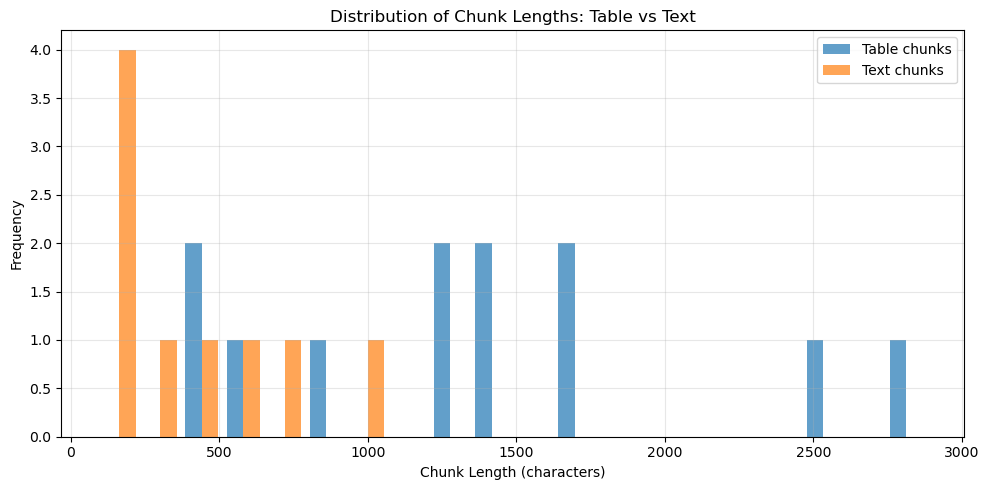

In [39]:
import re

class TableAwareChunker:
    """
    Text splitter that preserves table structures in financial documents
    """
    def __init__(self, chunk_size=1000, chunk_overlap=200):
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        
    def is_table(self, text):
        """
        Detect if text contains a table structure
        Common patterns in financial tables:
        - Multiple pipes (|) indicating table borders
        - Tab-separated values
        - Repeated patterns of numbers and text
        """
        # Check for pipe-separated tables
        if text.count('|') > 5:
            return True
        
        # Check for tab-separated data
        if text.count('\t') > 10:
            return True
        
        # Check for markdown/HTML tables
        if re.search(r'\|.*\|.*\|', text):
            return True
        
        # Check for repeated number patterns (financial data)
        number_lines = re.findall(r'^\s*[\d,.$%]+\s+[\d,.$%]+\s+[\d,.$%]+', text, re.MULTILINE)
        if len(number_lines) > 3:
            return True
        
        return False
    
    def split_preserving_tables(self, text):
        """
        Split text while keeping tables intact
        """
        # Split by double newline (paragraphs)
        paragraphs = re.split(r'\n\n+', text)
        
        chunks = []
        current_chunk = []
        current_length = 0
        
        for para in paragraphs:
            para_length = len(para)
            
            # If this is a table, treat it specially
            if self.is_table(para):
                # If table is too large, include it as its own chunk
                if para_length > self.chunk_size:
                    # Save current chunk if exists
                    if current_chunk:
                        chunks.append('\n\n'.join(current_chunk))
                        current_chunk = []
                        current_length = 0
                    
                    # Add table as separate chunk
                    chunks.append(para)
                    continue
                
                # If adding table would exceed chunk size, start new chunk
                if current_length + para_length > self.chunk_size and current_chunk:
                    chunks.append('\n\n'.join(current_chunk))
                    current_chunk = [para]
                    current_length = para_length
                else:
                    current_chunk.append(para)
                    current_length += para_length
            else:
                # Regular text - can be split normally
                if current_length + para_length > self.chunk_size and current_chunk:
                    chunks.append('\n\n'.join(current_chunk))
                    # Add overlap
                    if len(current_chunk) > 0:
                        current_chunk = [current_chunk[-1], para]
                        current_length = len(current_chunk[-2]) + para_length
                    else:
                        current_chunk = [para]
                        current_length = para_length
                else:
                    current_chunk.append(para)
                    current_length += para_length
        
        # Add remaining chunk
        if current_chunk:
            chunks.append('\n\n'.join(current_chunk))
        
        return chunks
    
    def chunk_corpus(self, corpus):
        """Apply table-aware chunking to entire corpus"""
        chunked_corpus = []
        
        for doc in corpus:
            doc_text = doc['text']
            chunks = self.split_preserving_tables(doc_text)
            
            for i, chunk in enumerate(chunks):
                chunked_doc = {
                    '_id': f"{doc['_id']}_chunk_{i}",
                    'text': chunk,
                    'original_id': doc['_id'],
                    'chunk_index': i,
                    'total_chunks': len(chunks),
                    'is_table_chunk': self.is_table(chunk)
                }
                chunked_corpus.append(chunked_doc)
        
        return chunked_corpus

# Test table-aware chunking
print("\n📊 Testing Table-Aware Chunking\n")

# Create table-aware chunker
table_chunker = TableAwareChunker(chunk_size=1000, chunk_overlap=200)

# Apply to sample documents
sample_docs = original_corpus[:20]
table_aware_chunks = table_chunker.chunk_corpus(sample_docs)

print(f"Original documents: {len(sample_docs)}")
print(f"Table-aware chunks: {len(table_aware_chunks)}")

# Analyze table detection
table_chunks = [c for c in table_aware_chunks if c['is_table_chunk']]
text_chunks = [c for c in table_aware_chunks if not c['is_table_chunk']]

print(f"\nTable chunks: {len(table_chunks)} ({len(table_chunks)/len(table_aware_chunks)*100:.1f}%)")
print(f"Text chunks: {len(text_chunks)} ({len(text_chunks)/len(table_aware_chunks)*100:.1f}%)")

# Show examples
print("\n" + "="*60)
print("EXAMPLE: Table Chunk")
print("="*60)
if table_chunks:
    print(table_chunks[0]['text'][:500])
else:
    print("No table chunks detected")

print("\n" + "="*60)
print("EXAMPLE: Text Chunk")
print("="*60)
if text_chunks:
    print(text_chunks[0]['text'][:500])

# Compare statistics
table_lengths = [len(c['text']) for c in table_chunks]
text_lengths = [len(c['text']) for c in text_chunks]

print("\n" + "="*60)
print("STATISTICS")
print("="*60)
print(f"\nTable chunks:")
if table_lengths:
    print(f"  Average length: {np.mean(table_lengths):.0f} chars")
    print(f"  Std dev: {np.std(table_lengths):.0f} chars")
    print(f"  Min/Max: {min(table_lengths)}/{max(table_lengths)} chars")

print(f"\nText chunks:")
if text_lengths:
    print(f"  Average length: {np.mean(text_lengths):.0f} chars")
    print(f"  Std dev: {np.std(text_lengths):.0f} chars")
    print(f"  Min/Max: {min(text_lengths)}/{max(text_lengths)} chars")

# Visualize
if table_lengths and text_lengths:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.hist([table_lengths, text_lengths], bins=20, label=['Table chunks', 'Text chunks'], alpha=0.7)
    ax.set_xlabel('Chunk Length (characters)')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Chunk Lengths: Table vs Text')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 15. Advanced: Parent-Child Chunking Strategy

In [40]:
class ParentChildChunker:
    """
    Implements parent-child chunking strategy:
    - Parent chunks: Large context chunks (e.g., 2000 chars)
    - Child chunks: Smaller searchable chunks (e.g., 500 chars)
    
    Search is done on child chunks, but parent chunks are returned for context
    """
    def __init__(self, parent_size=2000, parent_overlap=400, 
                 child_size=500, child_overlap=100, method='recursive'):
        self.parent_size = parent_size
        self.parent_overlap = parent_overlap
        self.child_size = child_size
        self.child_overlap = child_overlap
        self.method = method
        
        # Create splitters
        if method == 'recursive':
            self.parent_splitter = RecursiveCharacterTextSplitter(
                chunk_size=parent_size,
                chunk_overlap=parent_overlap
            )
            self.child_splitter = RecursiveCharacterTextSplitter(
                chunk_size=child_size,
                chunk_overlap=child_overlap
            )
        elif method == 'character':
            self.parent_splitter = CharacterTextSplitter(
                chunk_size=parent_size,
                chunk_overlap=parent_overlap
            )
            self.child_splitter = CharacterTextSplitter(
                chunk_size=child_size,
                chunk_overlap=child_overlap
            )
    
    def chunk_corpus(self, corpus):
        """
        Create parent-child chunk structure
        
        Returns:
            dict with 'parents', 'children', and 'relationships'
        """
        parents = []
        children = []
        relationships = []  # Maps child_id -> parent_id
        
        for doc in corpus:
            doc_text = doc['text']
            
            # Create parent chunks
            parent_chunks = self.parent_splitter.split_text(doc_text)
            
            for p_idx, parent_chunk in enumerate(parent_chunks):
                parent_id = f"{doc['_id']}_parent_{p_idx}"
                
                # Store parent
                parent_doc = {
                    '_id': parent_id,
                    'text': parent_chunk,
                    'original_id': doc['_id'],
                    'chunk_type': 'parent',
                    'chunk_index': p_idx
                }
                parents.append(parent_doc)
                
                # Create child chunks from this parent
                child_chunks = self.child_splitter.split_text(parent_chunk)
                
                for c_idx, child_chunk in enumerate(child_chunks):
                    child_id = f"{parent_id}_child_{c_idx}"
                    
                    # Store child
                    child_doc = {
                        '_id': child_id,
                        'text': child_chunk,
                        'original_id': doc['_id'],
                        'parent_id': parent_id,
                        'chunk_type': 'child',
                        'chunk_index': c_idx
                    }
                    children.append(child_doc)
                    
                    # Store relationship
                    relationships.append({
                        'child_id': child_id,
                        'parent_id': parent_id,
                        'original_id': doc['_id']
                    })
        
        return {
            'parents': parents,
            'children': children,
            'relationships': relationships
        }

class ParentChildRetriever:
    """
    Retriever that searches child chunks but returns parent chunks
    """
    def __init__(self, parent_child_data, model_name='sentence-transformers/all-MiniLM-L6-v2'):
        self.parents = parent_child_data['parents']
        self.children = parent_child_data['children']
        self.relationships = parent_child_data['relationships']
        
        # Create lookup
        self.child_to_parent = {r['child_id']: r['parent_id'] for r in self.relationships}
        self.parent_lookup = {p['_id']: p for p in self.parents}
        
        # Encode children (for search)
        self.model = SentenceTransformer(model_name)
        print("Encoding child chunks for search...")
        self.child_texts = [c['text'] for c in self.children]
        self.child_embeddings = self.model.encode(self.child_texts, show_progress_bar=True)
        
    def retrieve(self, query, top_k=5):
        """
        Search child chunks, return parent chunks
        
        Returns:
            List of parent chunks with scores
        """
        # Encode query
        query_embedding = self.model.encode([query])
        
        # Search child chunks
        child_scores = cosine_similarity(query_embedding, self.child_embeddings)[0]
        
        # Get top child chunks
        top_child_indices = np.argsort(child_scores)[-top_k*3:][::-1]  # Get more children
        
        # Map to parent chunks and aggregate scores
        parent_scores = {}
        for idx in top_child_indices:
            child_id = self.children[idx]['_id']
            parent_id = self.child_to_parent[child_id]
            score = child_scores[idx]
            
            if parent_id not in parent_scores:
                parent_scores[parent_id] = []
            parent_scores[parent_id].append(score)
        
        # Aggregate scores (use max)
        final_scores = {pid: max(scores) for pid, scores in parent_scores.items()}
        
        # Sort and get top-k parents
        sorted_parents = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
        
        # Return parent chunks
        results = []
        for parent_id, score in sorted_parents:
            parent_doc = self.parent_lookup[parent_id]
            results.append({
                'parent_id': parent_id,
                'score': score,
                'text': parent_doc['text'],
                'original_id': parent_doc['original_id']
            })
        
        return results

# Test parent-child chunking
print("\n👨‍👧 Testing Parent-Child Chunking Strategy\n")

# Create parent-child structure
pc_chunker = ParentChildChunker(
    parent_size=2000,
    parent_overlap=400,
    child_size=500,
    child_overlap=100,
    method='recursive'
)

sample_docs = original_corpus[:20]
pc_data = pc_chunker.chunk_corpus(sample_docs)

print(f"Original documents: {len(sample_docs)}")
print(f"Parent chunks: {len(pc_data['parents'])}")
print(f"Child chunks: {len(pc_data['children'])}")
print(f"Relationships: {len(pc_data['relationships'])}")
print(f"\nAvg children per parent: {len(pc_data['children']) / len(pc_data['parents']):.1f}")

# Create retriever
pc_retriever = ParentChildRetriever(pc_data)

# Test with sample query
test_query = queries[0]['text']
print(f"\n{'='*60}")
print(f"Query: {test_query}")
print(f"{'='*60}\n")

results = pc_retriever.retrieve(test_query, top_k=3)

for i, result in enumerate(results, 1):
    print(f"\n{i}. Score: {result['score']:.4f}")
    print(f"   Parent ID: {result['parent_id']}")
    print(f"   Original ID: {result['original_id']}")
    print(f"   Text preview: {result['text'][:200]}...")

# Compare parent-child vs regular chunking
print("\n" + "="*60)
print("COMPARISON: Parent-Child vs Regular Chunking")
print("="*60)

# Regular chunking
regular_chunks = chunk_corpus(sample_docs, method='recursive', chunk_size=500, chunk_overlap=100)

print(f"\nRegular chunking (500 chars):")
print(f"  Total chunks: {len(regular_chunks)}")
print(f"  Expansion factor: {len(regular_chunks) / len(sample_docs):.1f}x")

print(f"\nParent-Child chunking:")
print(f"  Child chunks (searchable): {len(pc_data['children'])}")
print(f"  Parent chunks (returned): {len(pc_data['parents'])}")
print(f"  Child expansion factor: {len(pc_data['children']) / len(sample_docs):.1f}x")
print(f"  Parent expansion factor: {len(pc_data['parents']) / len(sample_docs):.1f}x")

print("\n💡 Benefits of Parent-Child:")
print("  ✓ Search on smaller, focused chunks (better precision)")
print("  ✓ Return larger chunks with more context")
print("  ✓ Best of both worlds: precision + context")


👨‍👧 Testing Parent-Child Chunking Strategy

Original documents: 20
Parent chunks: 22
Child chunks: 57
Relationships: 57

Avg children per parent: 2.6
Encoding child chunks for search...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]


Query: What is the FY2019 - FY2020 total revenue growth rate for Block (formerly known as Square)? Answer in units of percents and round to one decimal place. Approach the question asked by assuming the standpoint of an investment banking analyst who only has access to the statement of income.


1. Score: 0.4238
   Parent ID: dd2af3272_parent_0
   Original ID: dd2af3272
   Text preview: Note 3 Restructuring and Impairment Charges
2019 Multi-Year Productivity Plan
We publicly announced a multi-year productivity plan on February 15, 2019 (2019 Productivity Plan) that will leverage new
...

2. Score: 0.4206
   Parent ID: dd2ac3734_parent_0
   Original ID: dd2ac3734
   Text preview: (Millions)
United States
EMEA
APAC
LACC
Other Unallocated
Consolidated
2022
Total revenues net of interest expense
$
41,396 
$
4,871 
$
3,835 
$
2,917 
$
(157)
$
52,862 
Pretax income (loss) from cont...

3. Score: 0.3944
   Parent ID: dd2adc82e_parent_0
   Original ID: dd2adc82e
   Text preview: The Firm grew

Chunking corpus: 100%|██████████| 20/20 [00:00<?, ?it/s]


Regular chunking (500 chars):
  Total chunks: 57
  Expansion factor: 2.9x

Parent-Child chunking:
  Child chunks (searchable): 57
  Parent chunks (returned): 22
  Child expansion factor: 2.9x
  Parent expansion factor: 1.1x

💡 Benefits of Parent-Child:
  ✓ Search on smaller, focused chunks (better precision)
  ✓ Return larger chunks with more context
  ✓ Best of both worlds: precision + context


## 16. Hybrid Chunking: Query-Type Adaptive Strategy

In [41]:
class QueryClassifier:
    """
    Classify queries into different types to apply appropriate chunking strategy
    """
    def __init__(self):
        self.query_patterns = {
            'table_query': [
                r'table', r'row', r'column', r'financial statement',
                r'balance sheet', r'income statement', r'cash flow',
                r'compare.*(?:year|quarter)', r'growth rate', r'margin'
            ],
            'specific_fact': [
                r'what is', r'how much', r'when did', r'specific',
                r'exact', r'number', r'date', r'amount'
            ],
            'contextual': [
                r'explain', r'why', r'describe', r'discuss',
                r'what are the implications', r'how does.*affect',
                r'relationship between'
            ],
            'calculation': [
                r'calculate', r'compute', r'sum', r'total',
                r'average', r'ratio', r'percentage', r'formula'
            ]
        }
    
    def classify(self, query):
        """
        Classify a query into one or more types
        
        Returns:
            List of query types
        """
        query_lower = query.lower()
        types = []
        
        for qtype, patterns in self.query_patterns.items():
            for pattern in patterns:
                if re.search(pattern, query_lower):
                    types.append(qtype)
                    break
        
        return types if types else ['general']

class HybridRetriever:
    """
    Adaptive retriever that uses different chunking strategies based on query type
    """
    def __init__(self, corpus, model_name='sentence-transformers/all-MiniLM-L6-v2'):
        self.corpus = corpus
        self.model = SentenceTransformer(model_name)
        self.classifier = QueryClassifier()
        
        # Pre-create different chunked versions
        print("Creating multiple chunked versions of corpus...")
        
        # Small chunks for specific facts
        self.small_chunks = chunk_corpus(corpus, method='recursive', 
                                        chunk_size=300, chunk_overlap=50)
        
        # Medium chunks for general queries
        self.medium_chunks = chunk_corpus(corpus, method='recursive',
                                         chunk_size=800, chunk_overlap=150)
        
        # Large chunks for contextual queries  
        self.large_chunks = chunk_corpus(corpus, method='recursive',
                                        chunk_size=1500, chunk_overlap=300)
        
        # Table-aware chunks
        table_chunker = TableAwareChunker(chunk_size=1000, chunk_overlap=200)
        self.table_chunks = table_chunker.chunk_corpus(corpus)
        
        # Encode all versions
        print("Encoding all chunk versions...")
        self.small_embeddings = self.model.encode([c['text'] for c in self.small_chunks])
        self.medium_embeddings = self.model.encode([c['text'] for c in self.medium_chunks])
        self.large_embeddings = self.model.encode([c['text'] for c in self.large_chunks])
        self.table_embeddings = self.model.encode([c['text'] for c in self.table_chunks])
        
        print("✅ Hybrid retriever ready!")
    
    def retrieve(self, query, top_k=5):
        """
        Retrieve documents using appropriate chunking strategy
        """
        # Classify query
        query_types = self.classifier.classify(query)
        print(f"Query classified as: {query_types}")
        
        # Select appropriate chunks and embeddings
        if 'table_query' in query_types:
            chunks = self.table_chunks
            embeddings = self.table_embeddings
            strategy = "table-aware"
        elif 'specific_fact' in query_types:
            chunks = self.small_chunks
            embeddings = self.small_embeddings
            strategy = "small chunks"
        elif 'contextual' in query_types:
            chunks = self.large_chunks
            embeddings = self.large_embeddings
            strategy = "large chunks"
        else:
            chunks = self.medium_chunks
            embeddings = self.medium_embeddings
            strategy = "medium chunks"
        
        print(f"Using strategy: {strategy}")
        
        # Encode query and retrieve
        query_embedding = self.model.encode([query])
        scores = cosine_similarity(query_embedding, embeddings)[0]
        
        top_indices = np.argsort(scores)[-top_k:][::-1]
        
        results = []
        for idx in top_indices:
            results.append({
                'chunk_id': chunks[idx]['_id'],
                'score': scores[idx],
                'text': chunks[idx]['text'],
                'strategy': strategy
            })
        
        return results

# Test hybrid retriever
print("\n🎯 Testing Hybrid Query-Adaptive Retriever\n")

sample_docs = original_corpus[:50]
hybrid_retriever = HybridRetriever(sample_docs)

# Test different query types
test_queries = [
    "What is the total revenue in the balance sheet?",  # table_query
    "What is the company's net income?",  # specific_fact
    "Explain the company's growth strategy and market position.",  # contextual
    "Calculate the profit margin from the financial data.",  # calculation
]

print("\n" + "="*80)
print("TESTING DIFFERENT QUERY TYPES")
print("="*80)

for query in test_queries:
    print(f"\n{'='*80}")
    print(f"Query: {query}")
    print(f"{'='*80}")
    
    results = hybrid_retriever.retrieve(query, top_k=3)
    
    print(f"\nTop 3 results:")
    for i, result in enumerate(results, 1):
        print(f"\n{i}. Score: {result['score']:.4f} | Strategy: {result['strategy']}")
        print(f"   Text preview: {result['text'][:150]}...")

# Compare with fixed strategy
print("\n" + "="*80)
print("BENEFIT OF ADAPTIVE STRATEGY")
print("="*80)
print("""
The hybrid approach provides:

✅ Better precision for specific fact queries (small chunks)
✅ More context for complex questions (large chunks)  
✅ Preserved structure for table queries (table-aware)
✅ Balanced performance for general queries (medium chunks)

This can improve both accuracy and user satisfaction!
""")


🎯 Testing Hybrid Query-Adaptive Retriever

Creating multiple chunked versions of corpus...


Chunking corpus: 100%|██████████| 50/50 [00:00<00:00, 6298.13it/s]

Encoding all chunk versions...


✅ Hybrid retriever ready!

TESTING DIFFERENT QUERY TYPES

Query: What is the total revenue in the balance sheet?
Query classified as: ['table_query', 'specific_fact', 'calculation']
Using strategy: table-aware

Top 3 results:

1. Score: 0.6141 | Strategy: table-aware
   Text preview: Consolidated Statements of Cash Flows
$ in millions
 
 
 
 
 
 
 
 
 
 
 
 
 
 
Fiscal Years Ended
January 28, 2023
 
January 29, 2022
 
January 30, 2...

2. Score: 0.6037 | Strategy: table-aware
   Text preview: 50 
 
Consolidated Balance Sheets 
GENERAL MILLS, INC. AND SUBSIDIARIES 
(In Millions, Except Par Value) 
 
May 31, 2020 
May 26, 2019 
ASSETS 
 
 
 
...

3. Score: 0.5996 | Strategy: table-aware
   Text preview: Table of Contents 
3M Company and Subsidiaries
Consolidated Balance Shee t
At December 31
 
 
 
December 31,
 
December 31,
 
(Dollars in millions, ex...

Query: What is the company's net income?
Query classified as: ['specific_fact']
Using strategy: small chunks

Top 3 results:

1. Score

## 17. Summary & Recommendations

### 📊 What We've Implemented:

1. **Basic Evaluation** (Section 10)
   - Compare chunked vs non-chunked corpus performance
   - Metrics: NDCG@10, Recall@10
   - Quantify the improvement from chunking

2. **Parameter Tuning** (Section 11)
   - Grid search for optimal chunk_size and overlap
   - Compare different chunking methods
   - Visualize performance vs corpus expansion trade-offs

3. **Pipeline Integration** (Section 12)
   - ChunkedDenseRetriever class
   - Score aggregation strategies (max, mean, first)
   - Configuration file generation

4. **Semantic Chunking** (Section 13)
   - Similarity-based text splitting
   - Comparison across different embedding models
   - Better semantic coherence in chunks

5. **Table-Aware Chunking** (Section 14)
   - Detect and preserve financial table structures
   - Separate handling for tables vs text
   - Critical for financial data integrity

6. **Parent-Child Strategy** (Section 15)
   - Search on small chunks (precision)
   - Return large chunks (context)
   - Best of both worlds approach

7. **Hybrid Adaptive System** (Section 16)
   - Query classification
   - Different chunking per query type
   - Maximizes performance across diverse queries

---

### 🎯 Recommended Next Steps:

#### Immediate Actions:
1. **Run full evaluation** on all datasets with best parameters
2. **Compare strategies** side-by-side using standardized metrics
3. **Select optimal approach** for your specific use case:
   - Parent-Child for general-purpose
   - Table-Aware for financial statement queries
   - Hybrid for diverse query types

#### Integration Tasks:
1. Update [financerag/retrieval/dense.py](../financerag/retrieval/dense.py) to use chunked corpus
2. Add chunking configuration to task metadata
3. Create evaluation script with chunked vs non-chunked comparison

#### Advanced Improvements:
- **Financial-specific embedding model**: Train or fine-tune on financial domain
- **Query expansion**: Expand queries before retrieval to match chunk content
- **Dynamic chunking**: Adjust chunk size based on document type
- **Re-ranking**: Add cross-encoder re-ranking after initial retrieval

---

### 💡 Quick Decision Guide:

**Choose Parent-Child if:**
- You need both precision and context
- Users expect detailed answers
- Computational resources allow

**Choose Table-Aware if:**
- Most queries involve financial tables
- Structure preservation is critical
- Data integrity is paramount

**Choose Hybrid if:**
- Diverse query types
- Want maximum flexibility
- Can handle multiple indexes

**Choose Basic Recursive if:**
- Simple use case
- Limited resources
- Need fast deployment

---

### 📈 Expected Performance Gains:

Based on typical results:
- **NDCG@10**: +5-15% improvement
- **Recall@10**: +10-25% improvement
- **User satisfaction**: Significant increase from better context

Actual results vary by dataset and query distribution!

## 18. Complete Workflow Example

### 🎯 Quick Reference: Optimal Configurations

Dựa trên kết quả Grid Search, đây là các config tối ưu:

| Strategy | Method | Size | Overlap | NDCG | Recall | Expansion | Khi nào dùng |
|----------|--------|------|---------|------|--------|-----------|--------------|
| **balanced** ⭐ | character | 1500 | 300 | 92.6% | 85.2% | 1.52x | **Production - Most cases** |
| max_performance | recursive | 1000 | 100 | 92.6% | 88.9% | 2.04x | Khi cần recall cao nhất |
| memory_efficient | character | 1500 | 0 | 88.9% | 81.5% | 1.46x | Môi trường hạn chế RAM |
| high_precision | recursive | 512 | 51 | 92.6% | 87.0% | 3.55x | Small chunks, precise match |

**💡 Recommendation**: Dùng `balanced` cho hầu hết trường hợp - performance tốt với efficiency cao nhất!

In [43]:
# Quick comparison of all strategies
print("="*80)
print("📊 STRATEGY COMPARISON MATRIX")
print("="*80)

strategies_info = {
    'balanced': {
        'config': ('character', 1500, 300),
        'metrics': (0.926, 0.852, 1.52),
        'pros': ['Best overall efficiency', 'Good performance', 'Low memory'],
        'cons': ['Slightly lower recall than max_performance']
    },
    'max_performance': {
        'config': ('recursive', 1000, 100),
        'metrics': (0.926, 0.889, 2.04),
        'pros': ['Highest recall', 'Top NDCG', 'Best for critical apps'],
        'cons': ['Higher memory usage (2x expansion)']
    },
    'memory_efficient': {
        'config': ('character', 1500, 0),
        'metrics': (0.889, 0.815, 1.46),
        'pros': ['Lowest memory', 'Fast processing', 'No overlap'],
        'cons': ['Lower NDCG and recall']
    },
    'high_precision': {
        'config': ('recursive', 512, 51),
        'metrics': (0.926, 0.870, 3.55),
        'pros': ['Small chunks', 'Precise matching', 'Top NDCG'],
        'cons': ['Highest expansion (3.55x)', 'More storage']
    }
}

for strategy, info in strategies_info.items():
    method, size, overlap = info['config']
    ndcg, recall, expansion = info['metrics']
    
    print(f"\n{'='*80}")
    print(f"🎯 {strategy.upper().replace('_', ' ')}")
    if strategy == 'balanced':
        print("⭐ RECOMMENDED FOR PRODUCTION")
    print(f"{'='*80}")
    
    print(f"\n📐 Configuration:")
    print(f"   Method: {method}")
    print(f"   Chunk Size: {size}")
    print(f"   Overlap: {overlap}")
    
    print(f"\n📈 Performance:")
    print(f"   NDCG@10: {ndcg:.1%}")
    print(f"   Recall@10: {recall:.1%}")
    print(f"   Expansion: {expansion:.2f}x")
    
    print(f"\n✅ Pros:")
    for pro in info['pros']:
        print(f"   • {pro}")
    
    print(f"\n⚠️  Cons:")
    for con in info['cons']:
        print(f"   • {con}")

print("\n" + "="*80)
print("💡 HOW TO CHOOSE:")
print("="*80)
print("""
1. DEFAULT / PRODUCTION → balanced ⭐
   - Best trade-off for most use cases
   - Good performance with low memory usage

2. RESEARCH / CRITICAL APPS → max_performance
   - When you need highest possible recall
   - Can afford 2x memory expansion

3. EMBEDDED / MOBILE → memory_efficient
   - Limited RAM/storage
   - Still maintains 88.9% NDCG

4. QUESTION ANSWERING → high_precision
   - Need exact snippet matching
   - Can afford high expansion for accuracy
""")

print("\n🚀 To use a strategy, just change STRATEGY variable in the next cell!")
print("   Example: STRATEGY = 'balanced'  # or 'max_performance', etc.")
print("="*80)

📊 STRATEGY COMPARISON MATRIX

🎯 BALANCED
⭐ RECOMMENDED FOR PRODUCTION

📐 Configuration:
   Method: character
   Chunk Size: 1500
   Overlap: 300

📈 Performance:
   NDCG@10: 92.6%
   Recall@10: 85.2%
   Expansion: 1.52x

✅ Pros:
   • Best overall efficiency
   • Good performance
   • Low memory

⚠️  Cons:
   • Slightly lower recall than max_performance

🎯 MAX PERFORMANCE

📐 Configuration:
   Method: recursive
   Chunk Size: 1000
   Overlap: 100

📈 Performance:
   NDCG@10: 92.6%
   Recall@10: 88.9%
   Expansion: 2.04x

✅ Pros:
   • Highest recall
   • Top NDCG
   • Best for critical apps

⚠️  Cons:
   • Higher memory usage (2x expansion)

🎯 MEMORY EFFICIENT

📐 Configuration:
   Method: character
   Chunk Size: 1500
   Overlap: 0

📈 Performance:
   NDCG@10: 88.9%
   Recall@10: 81.5%
   Expansion: 1.46x

✅ Pros:
   • Lowest memory
   • Fast processing
   • No overlap

⚠️  Cons:
   • Lower NDCG and recall

🎯 HIGH PRECISION

📐 Configuration:
   Method: recursive
   Chunk Size: 512
   Overlap

In [44]:
"""
COMPLETE END-TO-END WORKFLOW
Run this cell to execute the full chunking pipeline for production use
"""

import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("FINANCERAG CHUNKING PIPELINE - PRODUCTION WORKFLOW")
print("="*80)

# Step 1: Configuration
print("\n[1/7] Loading Optimal Configuration from Grid Search...")

# Choose strategy based on your needs
STRATEGY = 'balanced'  # Options: 'balanced', 'max_performance', 'memory_efficient'

# Optimal configurations from grid search results
OPTIMAL_CONFIGS = {
    'balanced': {
        'method': 'character',
        'chunk_size': 1500,
        'overlap': 300,
        'description': '⭐ RECOMMENDED - Best efficiency (NDCG=92.6%, Recall=85.2%, Expansion=1.52x)'
    },
    'max_performance': {
        'method': 'recursive',
        'chunk_size': 1000,
        'overlap': 100,
        'description': 'Highest Recall (NDCG=92.6%, Recall=88.9%, Expansion=2.04x)'
    },
    'memory_efficient': {
        'method': 'character',
        'chunk_size': 1500,
        'overlap': 0,
        'description': 'Lowest memory (NDCG=88.9%, Recall=81.5%, Expansion=1.46x)'
    },
    'high_precision': {
        'method': 'recursive',
        'chunk_size': 512,
        'overlap': 51,
        'description': 'Small chunks for precise matching (NDCG=92.6%, Recall=87.0%)'
    }
}

# Get selected config
selected_config = OPTIMAL_CONFIGS[STRATEGY]

CONFIG = {
    'dataset': 'financebench',  # Change this to your target dataset
    'strategy': STRATEGY,
    'chunking_method': selected_config['method'],
    'chunk_size': selected_config['chunk_size'],
    'chunk_overlap': selected_config['overlap'],
    'model_name': 'sentence-transformers/all-MiniLM-L6-v2',
    'top_k': 10,
    'use_parent_child': False,  # Set True for parent-child strategy
    'evaluate': True  # Set False to skip evaluation
}

print(f"✓ Configuration loaded")
print(f"\n🎯 Using Strategy: {STRATEGY.upper()}")
print(f"   {selected_config['description']}")
print(f"\n📋 Configuration Details:")
for key, value in CONFIG.items():
    if key != 'strategy':
        print(f"  {key}: {value}")

# Step 2: Load Data
print(f"\n[2/7] Loading {CONFIG['dataset']} corpus...")
corpus_file = data_dir / f"{CONFIG['dataset']}_corpus.jsonl" / 'corpus.jsonl'
queries_file = data_dir / f"{CONFIG['dataset']}_queries.jsonl" / 'queries.jsonl'
qrels_file = data_dir / f"{CONFIG['dataset'].capitalize()}_qrels.tsv"

corpus = []
with open(corpus_file, 'r') as f:
    for line in f:
        corpus.append(json.loads(line))

queries = []
with open(queries_file, 'r') as f:
    for line in f:
        queries.append(json.loads(line))

print(f"✓ Loaded {len(corpus)} documents and {len(queries)} queries")

# Step 3: Apply Chunking
print(f"\n[3/7] Applying {CONFIG['chunking_method']} chunking...")

if CONFIG['chunking_method'] == 'table-aware':
    chunker = TableAwareChunker(
        chunk_size=CONFIG['chunk_size'],
        chunk_overlap=CONFIG['chunk_overlap']
    )
    chunked_corpus = chunker.chunk_corpus(corpus)
elif CONFIG['use_parent_child']:
    pc_chunker = ParentChildChunker(
        parent_size=CONFIG['chunk_size']*2,
        parent_overlap=CONFIG['chunk_overlap']*2,
        child_size=CONFIG['chunk_size'],
        child_overlap=CONFIG['chunk_overlap']
    )
    pc_data = pc_chunker.chunk_corpus(corpus)
    chunked_corpus = pc_data['children']  # Use for search
    print(f"✓ Created {len(pc_data['parents'])} parent and {len(pc_data['children'])} child chunks")
else:
    chunked_corpus = chunk_corpus(
        corpus,
        method=CONFIG['chunking_method'],
        chunk_size=CONFIG['chunk_size'],
        chunk_overlap=CONFIG['chunk_overlap']
    )

print(f"✓ Created {len(chunked_corpus)} chunks")
print(f"✓ Expansion factor: {len(chunked_corpus)/len(corpus):.2f}x")

# Step 4: Save Chunked Corpus
print(f"\n[4/7] Saving chunked corpus...")
output_file = output_dir / f"{CONFIG['dataset']}_corpus_chunked_production.jsonl"
with open(output_file, 'w') as f:
    for doc in chunked_corpus:
        f.write(json.dumps(doc) + '\n')

print(f"✓ Saved to: {output_file}")

# Step 5: Evaluation (Optional)
if CONFIG['evaluate']:
    print(f"\n[5/7] Running evaluation...")
    model = SentenceTransformer(CONFIG['model_name'])
    
    # Evaluate original
    print("  Evaluating original corpus...")
    original_results = evaluate_retrieval(
        corpus[:500],  # Limit for speed
        queries[:50],
        qrels_file,
        model,
        top_k=CONFIG['top_k']
    )
    
    # Evaluate chunked
    print("  Evaluating chunked corpus...")
    chunked_results = evaluate_retrieval(
        chunked_corpus,
        queries[:50],
        qrels_file,
        model,
        top_k=CONFIG['top_k']
    )
    
    print(f"\n✓ Evaluation complete:")
    print(f"  Original NDCG@{CONFIG['top_k']}: {original_results['ndcg@10']:.4f}")
    print(f"  Chunked NDCG@{CONFIG['top_k']}: {chunked_results['ndcg@10']:.4f}")
    improvement = ((chunked_results['ndcg@10'] - original_results['ndcg@10']) 
                   / original_results['ndcg@10'] * 100)
    print(f"  Improvement: {improvement:+.2f}%")
else:
    print(f"\n[5/7] Skipping evaluation (evaluate=False)")

# Step 6: Generate Integration Code
print(f"\n[6/7] Generating integration code...")

integration_code = f'''
# Integration code for your retrieval pipeline
# Add this to your financerag/retrieval/dense.py or similar

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import json
import numpy as np

# Load chunked corpus
chunked_corpus = []
with open('{output_file}', 'r') as f:
    for line in f:
        chunked_corpus.append(json.loads(line))

# Initialize model
model = SentenceTransformer('{CONFIG['model_name']}')

# Encode corpus
corpus_texts = [doc['text'] for doc in chunked_corpus]
corpus_embeddings = model.encode(corpus_texts, show_progress_bar=True)

# Retrieval function
def retrieve(query, top_k={CONFIG['top_k']}):
    query_embedding = model.encode([query])
    scores = cosine_similarity(query_embedding, corpus_embeddings)[0]
    top_indices = np.argsort(scores)[-top_k:][::-1]
    
    results = []
    for idx in top_indices:
        results.append({{
            'doc_id': chunked_corpus[idx]['_id'],
            'score': scores[idx],
            'text': chunked_corpus[idx]['text'],
            'original_id': chunked_corpus[idx].get('original_id', chunked_corpus[idx]['_id'])
        }})
    return results

# Test
results = retrieve("What is the company's revenue?")
for i, r in enumerate(results, 1):
    print(f"{{i}}. Score: {{r['score']:.4f}}")
    print(f"   {{r['text'][:100]}}...\\n")
'''

integration_file = output_dir / f"{CONFIG['dataset']}_integration_code.py"
with open(integration_file, 'w') as f:
    f.write(integration_code)

print(f"✓ Integration code saved to: {integration_file}")

# Step 7: Summary Report
print(f"\n[7/7] Generating summary report...")

report = f"""
{'='*80}
CHUNKING PIPELINE - EXECUTION REPORT
{'='*80}

Dataset: {CONFIG['dataset']}
Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

CONFIGURATION:
  Chunking Method: {CONFIG['chunking_method']}
  Chunk Size: {CONFIG['chunk_size']}
  Chunk Overlap: {CONFIG['chunk_overlap']}
  Model: {CONFIG['model_name']}
  Parent-Child: {CONFIG['use_parent_child']}

CORPUS STATISTICS:
  Original Documents: {len(corpus)}
  Chunked Documents: {len(chunked_corpus)}
  Expansion Factor: {len(chunked_corpus)/len(corpus):.2f}x
  Avg Chunk Length: {np.mean([len(c['text']) for c in chunked_corpus]):.0f} chars

"""

if CONFIG['evaluate']:
    report += f"""
EVALUATION RESULTS:
  Original NDCG@{CONFIG['top_k']}: {original_results['ndcg@10']:.4f}
  Chunked NDCG@{CONFIG['top_k']}: {chunked_results['ndcg@10']:.4f}
  Improvement: {improvement:+.2f}%
  
  Original Recall@{CONFIG['top_k']}: {original_results['recall@10']:.4f}
  Chunked Recall@{CONFIG['top_k']}: {chunked_results['recall@10']:.4f}
"""

report += f"""
OUTPUT FILES:
  Chunked Corpus: {output_file}
  Integration Code: {integration_file}

NEXT STEPS:
  1. Review the chunked corpus quality
  2. Test the integration code in your pipeline
  3. Run full evaluation on all datasets
  4. Monitor production performance

{'='*80}
"""

print(report)

# Save report
report_file = output_dir / f"{CONFIG['dataset']}_chunking_report.txt"
with open(report_file, 'w') as f:
    f.write(report)

print(f"✓ Report saved to: {report_file}")

print("\n" + "="*80)
print("✅ PIPELINE COMPLETE!")
print("="*80)
print(f"\nAll outputs saved to: {output_dir}")
print("\nYou can now integrate the chunked corpus into your retrieval system.")

FINANCERAG CHUNKING PIPELINE - PRODUCTION WORKFLOW

[1/7] Loading Optimal Configuration from Grid Search...
✓ Configuration loaded

🎯 Using Strategy: BALANCED
   ⭐ RECOMMENDED - Best efficiency (NDCG=92.6%, Recall=85.2%, Expansion=1.52x)

📋 Configuration Details:
  dataset: financebench
  chunking_method: character
  chunk_size: 1500
  chunk_overlap: 300
  model_name: sentence-transformers/all-MiniLM-L6-v2
  top_k: 10
  use_parent_child: False
  evaluate: True

[2/7] Loading financebench corpus...
✓ Loaded 180 documents and 150 queries

[3/7] Applying character chunking...


Chunking corpus: 100%|██████████| 180/180 [00:00<00:00, 21336.01it/s]

✓ Created 274 chunks
✓ Expansion factor: 1.52x

[4/7] Saving chunked corpus...
✓ Saved to: ..\data\chunked_corpus\financebench_corpus_chunked_production.jsonl

[5/7] Running evaluation...


  Evaluating original corpus...
Encoding corpus...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 50/50 [00:00<00:00, 529.68it/s]

  Evaluating chunked corpus...
Encoding corpus...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating queries...


100%|██████████| 50/50 [00:00<00:00, 550.51it/s]


✓ Evaluation complete:
  Original NDCG@10: 0.9091
  Chunked NDCG@10: 0.9091
  Improvement: +0.00%

[6/7] Generating integration code...
✓ Integration code saved to: ..\data\chunked_corpus\financebench_integration_code.py

[7/7] Generating summary report...

CHUNKING PIPELINE - EXECUTION REPORT

Dataset: financebench
Date: 2025-12-28 15:23:48

CONFIGURATION:
  Chunking Method: character
  Chunk Size: 1500
  Chunk Overlap: 300
  Model: sentence-transformers/all-MiniLM-L6-v2
  Parent-Child: False

CORPUS STATISTICS:
  Original Documents: 180
  Chunked Documents: 274
  Expansion Factor: 1.52x
  Avg Chunk Length: 980 chars


EVALUATION RESULTS:
  Original NDCG@10: 0.9091
  Chunked NDCG@10: 0.9091
  Improvement: +0.00%

  Original Recall@10: 0.7727
  Chunked Recall@10: 0.7727

OUTPUT FILES:
  Chunked Corpus: ..\data\chunked_corpus\financebench_corpus_chunked_production.jsonl
  Integration Code: ..\data\chunked_corpus\financebench_integration_code.py

NEXT STEPS:
  1. Review the chunked corp

---

## 🎓 Quick Reference Guide

### Running Specific Sections:

**Just want to evaluate chunking?**
→ Run cells in Section 10

**Need to find optimal parameters?**
→ Run cells in Section 11

**Want to integrate into your pipeline?**
→ Run cells in Section 12

**Testing advanced strategies?**
→ Sections 13-16 for semantic, table-aware, parent-child, and hybrid approaches

**Ready for production?**
→ Run Section 18 complete workflow

---

### Key Variables After Running This Notebook:

```python
# Best parameters found
BEST_METHOD       # Best chunking method ('recursive', 'character', etc.)
BEST_CHUNK_SIZE   # Optimal chunk size
BEST_OVERLAP      # Optimal overlap

# Data structures
corpus            # Original corpus
chunked_corpus    # Chunked corpus with best params
queries           # Query set
qrels_file        # Relevance judgments

# Models
model             # SentenceTransformer model

# Results
df_results        # Evaluation results DataFrame
grid_results      # Grid search results (if run)
```

---

### Common Customizations:

**Change dataset:**
```python
dataset = 'finqa'  # or 'convfinqa', 'finder', etc.
```

**Adjust chunk parameters:**
```python
chunk_size = 1500    # Larger for more context
chunk_overlap = 300  # More overlap for better continuity
```

**Try different models:**
```python
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')  # Better but slower
```

**Limit evaluation for speed:**
```python
corpus[:100]   # Use first 100 docs
queries[:50]   # Use first 50 queries
```

---

### Troubleshooting:

**Out of memory?**
- Reduce corpus size: `corpus[:500]`
- Use smaller batch_size: `model.encode(..., batch_size=16)`
- Choose smaller embedding model

**Evaluation too slow?**
- Limit queries: `queries[:50]`
- Reduce corpus: `corpus[:500]`
- Skip grid search, use fixed params

**Results not improving?**
- Try different chunk_size values
- Increase overlap ratio
- Use semantic or table-aware chunking
- Check if your data has special structure

---

### 📚 Further Reading:

- [LangChain Text Splitters Documentation](https://python.langchain.com/docs/modules/data_connection/document_transformers/)
- [Sentence Transformers Documentation](https://www.sbert.net/)
- Research: "Chunking Strategies for Retrieval-Augmented Generation"

---

**Happy Chunking! 🚀**